In [2]:
# import necessary libraries

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
# import train dataset
df_train = pd.read_csv("train.csv")

# size of train dataset
df_train.shape

(9557, 143)

In [4]:
# import test dataset
df_test = pd.read_csv("test.csv")

# size of test dataset
df_test.shape

(23856, 142)

The test dataset has one column less than the train dataset. This is the target variable.

### Identify the output variable

In [5]:
# find the name of the output variable
set(df_train.columns)-set(df_test.columns)

{'Target'}

In [6]:
# get unique values of the output variable together with their counts
df_train['Target'].value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

The output variable "Target" specifies the level of poverty and has 4 categories:
- 1 = extreme poverty
- 2 = moderate poverty
- 3 = vulnerable households
- 4 = non vulnerable households

It's a categorical variable that is already available in numerical format.

### Understand the type of data

In [7]:
# get and count data types of columns in train dataset
df_train.dtypes.value_counts()

int64      130
float64      8
object       5
dtype: int64

In [8]:
# get and count data types of columns in test dataset
df_test.dtypes.value_counts()

int64      129
float64      8
object       5
dtype: int64

In [9]:
# look at the object features
df_train.select_dtypes(include='object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


- According to the description file, most of the integer columns are bincary data with 0 and 1 entries.
- The five object variables are:
 - Id = Unique ID --> we can remove this column
 - idhogar = Household level identifier
 - dependency = Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64). Has mixed numeric and string entries!
 - edjefe = edjefe, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
 - edjefa = edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

In [10]:
# remove Id column from train and test data
df_train = df_train.drop(['Id'], axis=1)
df_test = df_test.drop(['Id'], axis=1)

In [11]:
# convert variables edjefe and edjefa to fully numerical variables: yes=1 and no=0
# we do the same for variable dependency (although it's not specified what value yes and no should have)
df_train['edjefe'].replace({'yes': 1, 'no': 0}, inplace=True)
df_train['edjefa'].replace({'yes': 1, 'no': 0}, inplace=True)
df_train['dependency'].replace({'yes': 1, 'no': 0}, inplace=True)
df_test['edjefe'].replace({'yes': 1, 'no': 0}, inplace=True)
df_test['edjefa'].replace({'yes': 1, 'no': 0}, inplace=True)
df_test['dependency'].replace({'yes': 1, 'no': 0}, inplace=True)

In [12]:
# look again at the object features
df_train.select_dtypes(include='object').head()

,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,0,10,0
1,0e5d7a658,8,12,0
2,2c7317ea8,8,0,11
3,2b58d945f,1,11,0
4,2b58d945f,1,11,0


Variables dependency, edjefe, and edjefa are still stored as objects. Cast them into int/float:

In [13]:
df_train['edjefe'] = df_train.edjefe.astype(int)
df_train['edjefa'] = df_train.edjefa.astype(int)
df_train['dependency'] = df_train.dependency.astype(float)

df_test['edjefe'] = df_test.edjefe.astype(int)
df_test['edjefa'] = df_test.edjefa.astype(int)
df_test['dependency'] = df_test.dependency.astype(float)

In [14]:
# look again at the object features
df_train.select_dtypes(include='object').head()

,idhogar
0,21eb7fcc1
1,0e5d7a658
2,2c7317ea8
3,2b58d945f
4,2b58d945f


### Check if there are any biases in your dataset

##### Check distribution of target variable

In [15]:
# get percentage of the count of unique values in the output variable
df_train['Target'].value_counts()*100/df_train['Target'].shape[0]

4    62.739353
2    16.710265
3    12.650413
1     7.899969
Name: Target, dtype: float64

The four levels of poverty have very different counts in the training dataset.

#### Check distribution of feature variables

In [16]:
# get percentage of the count of missing values in each feature
(df_train.isnull().sum()*100/df_train.shape[0]).sort_values()

eviv2          0.000000
instlevel1     0.000000
edjefa         0.000000
edjefe         0.000000
dependency     0.000000
                ...    
SQBmeaned      0.052318
meaneduc       0.052318
v2a1          71.779847
v18q1         76.823271
rez_esc       82.954902
Length: 142, dtype: float64

In [17]:
# get percentage of the count of unique values for each column of the train data
for cols in df_train.columns:
    print(df_train[cols].value_counts().sort_values()*100/df_train[cols].shape[0])

108000.0    0.010464
234000.0    0.010464
249896.0    0.010464
125518.0    0.010464
25310.0     0.010464
              ...   
50000.0     1.234697
120000.0    1.559067
200000.0    1.663702
100000.0    1.893900
150000.0    2.438004
Name: v2a1, Length: 157, dtype: float64
1     3.808727
0    96.191273
Name: hacdor, dtype: float64
11     0.073245
10     0.449932
1      1.014963
9      1.757874
2      1.967145
8      3.118133
7      7.659307
3      9.312546
6     16.814900
4     27.069164
5     30.762792
Name: rooms, dtype: float64
1     2.364759
0    97.635241
Name: hacapo, dtype: float64
0     0.523177
1    99.476823
Name: v14a, dtype: float64
0     4.237732
1    95.762268
Name: refrig, dtype: float64
1    23.176729
0    76.823271
Name: v18q, dtype: float64
6.0     0.062781
5.0     0.136026
4.0     0.387151
3.0     1.349796
2.0     4.645809
1.0    16.595166
Name: v18q1, dtype: float64
4     0.167417
5     0.230198
3     0.554567
2     6.351365
1    22.402428
0    70.294025
Name: r4h1, dt

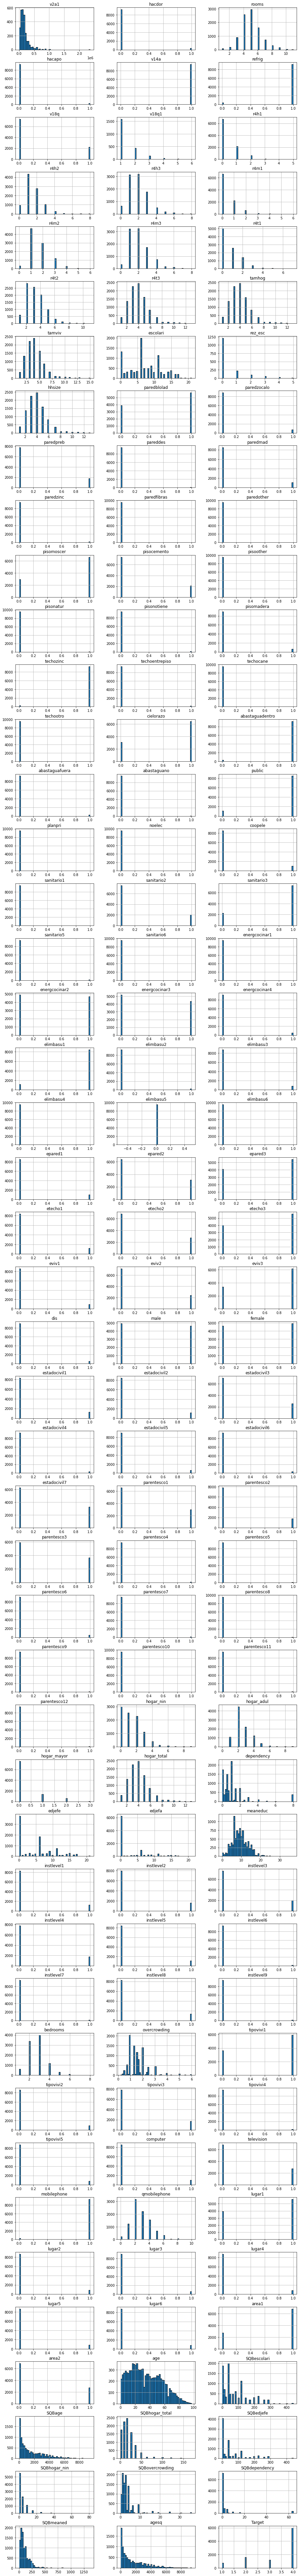

In [18]:
# visualize features as histograms
df_train.hist(figsize=(15,140), ec="k", bins=50, layout=(47,3))
plt.show()

Most of the binary variables have much more representations of one value over the other (see below for some examples):

v2a1, monthly rent payment:
- most data lies between 100000-20000
- but has lots of missing values: 72% of the data is missing

hacdor/hacapo, overcrowding by bedrooms/rooms: binary variables; ~97% have value 0 each

v14a/refrig, household has bathroom/refrigerator: binary variables; ~97% has value 1 each

v18q, owns a tablet: binary variable; 77% has value 1

v18q1, number of tablets household owns:
- most data has value 1
- but has lots of missing values: 77% of the data is missing

r4h1/r4m1, males/females younger than 12 years of age: ~70% have value 0 each

r4h2/r4m2, males/females 12 years of age and older: ~47% have value 1 each

r4t1, persons younger than 12 years of age: 52% has value 0

rez_esc, years behind in school:
- most data has value 0
- but has lots of missing values: 83% of the data is missing

For seven of the eight binary variables called "pared_", indicating specific predominant material on the outside, 81-99% have value 0 each.

For five of the six binary variables called "piso_", indicating specific predominant material on the floor, 78-99.9% have value 0 each.

For the four binary variables called "techo_", indicating specific predominant material on the roof, 97-99.8% have either value 0 or 1 each.

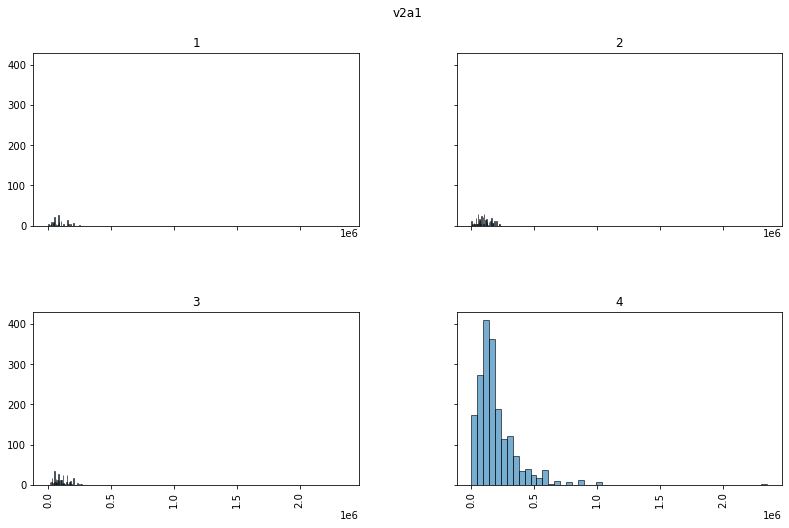

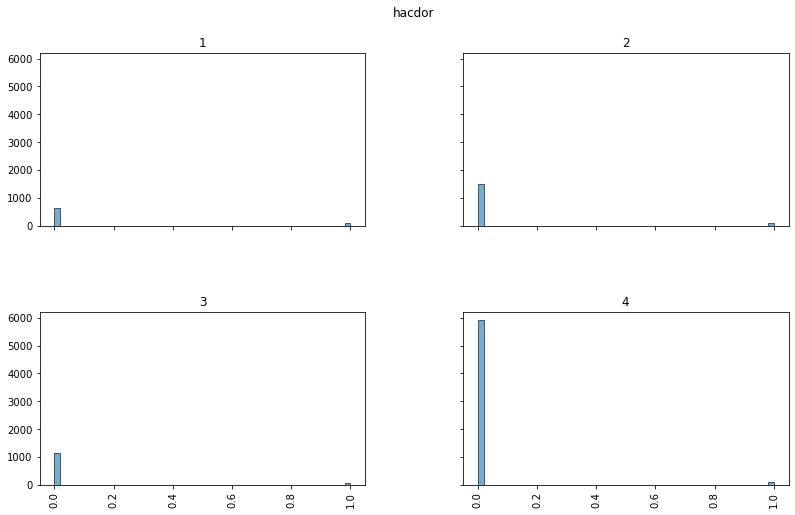

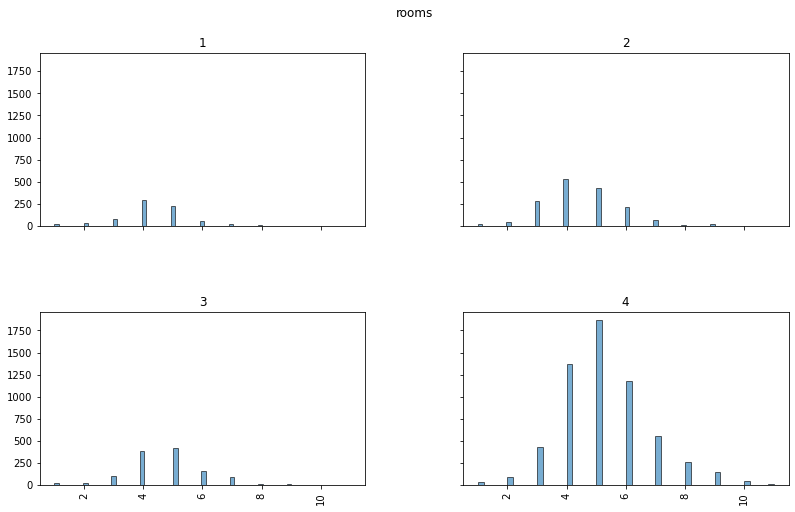

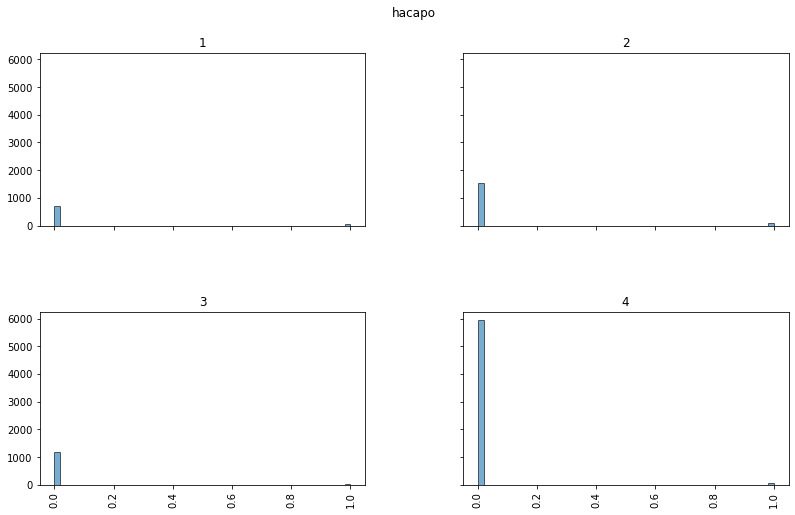

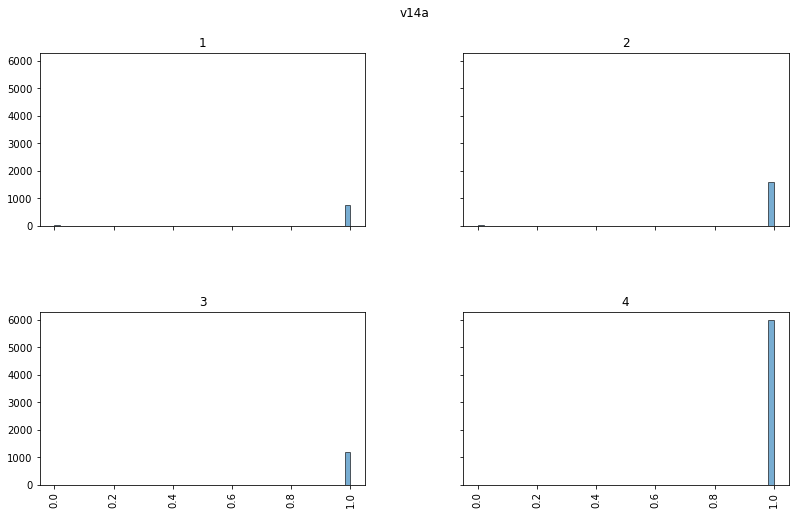

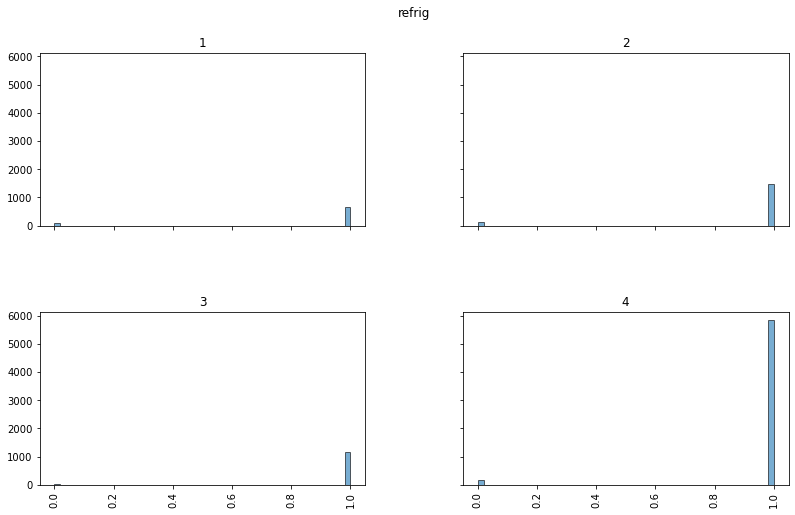

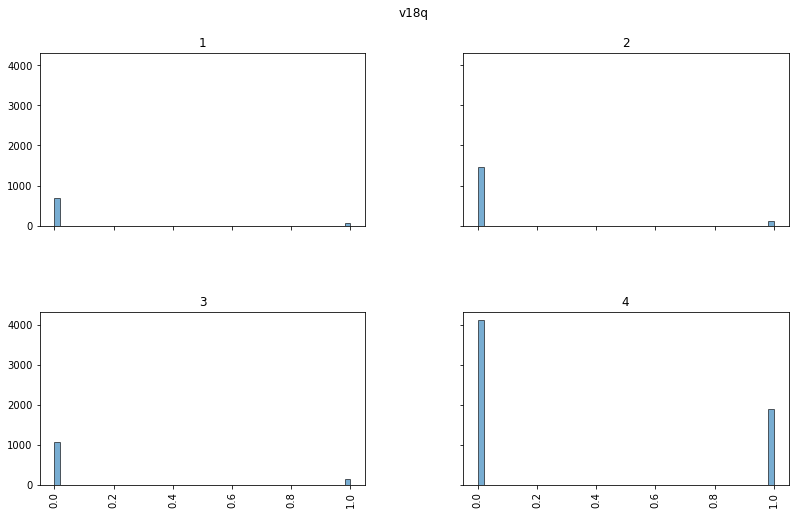

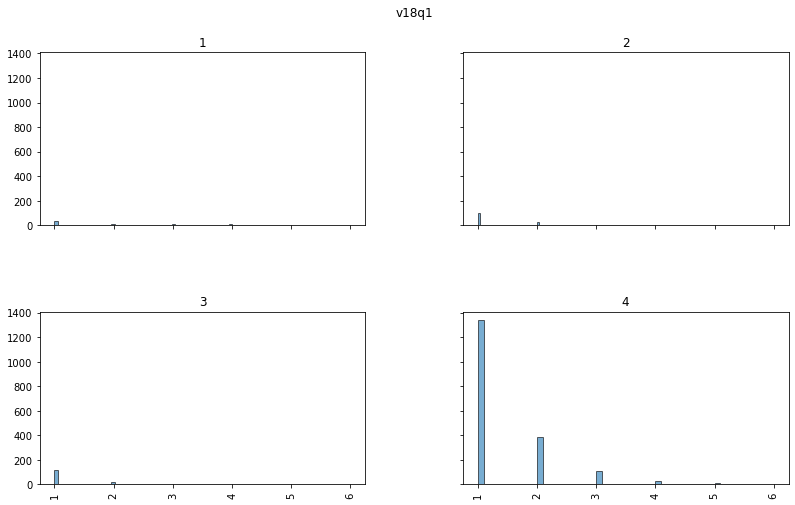

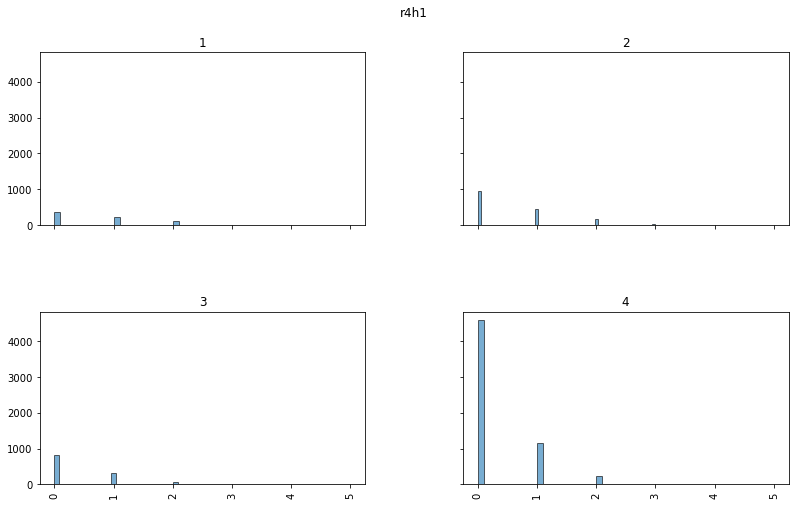

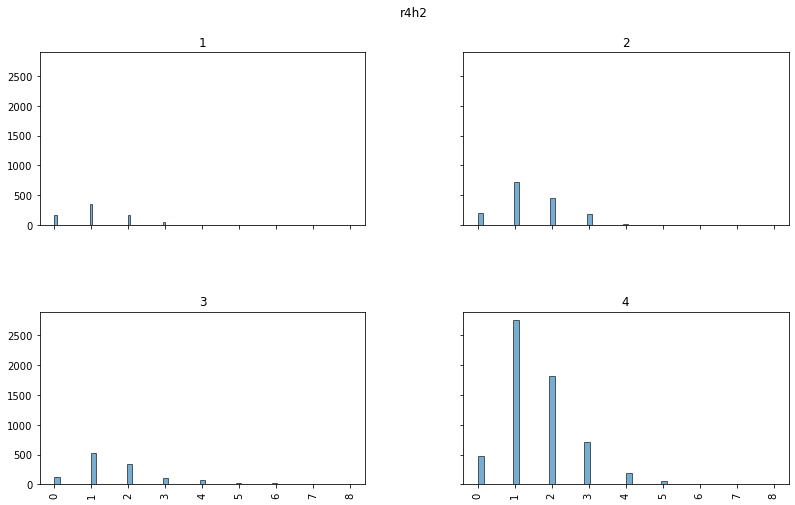

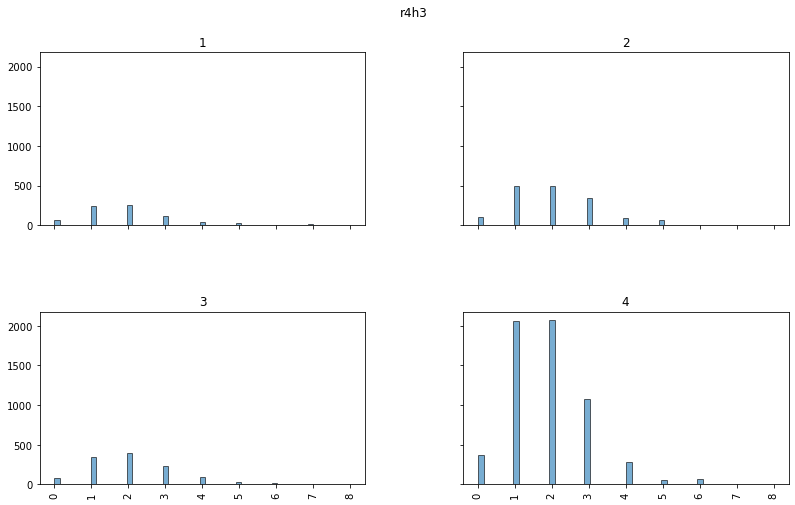

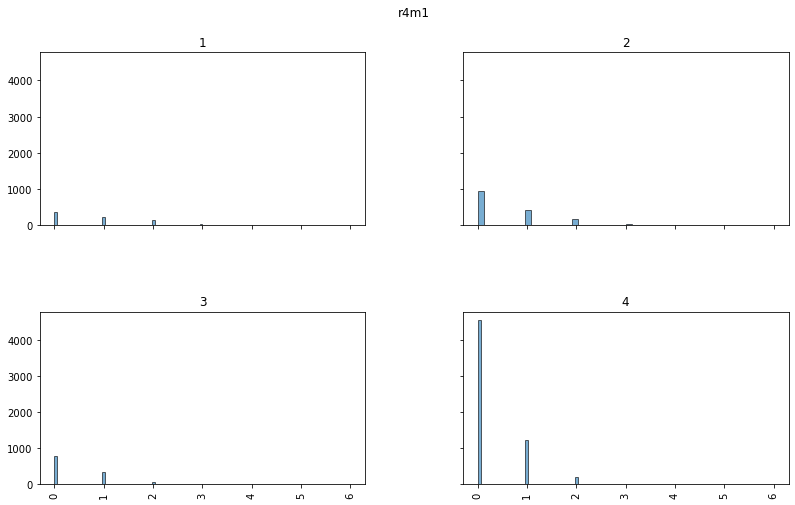

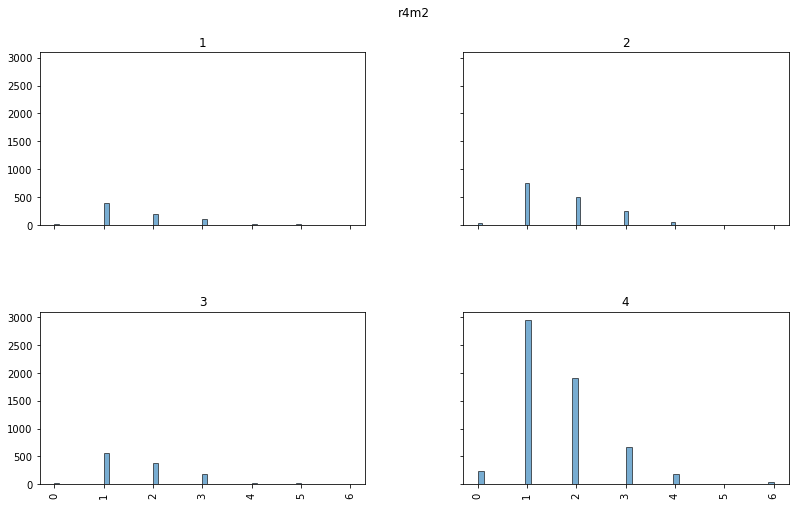

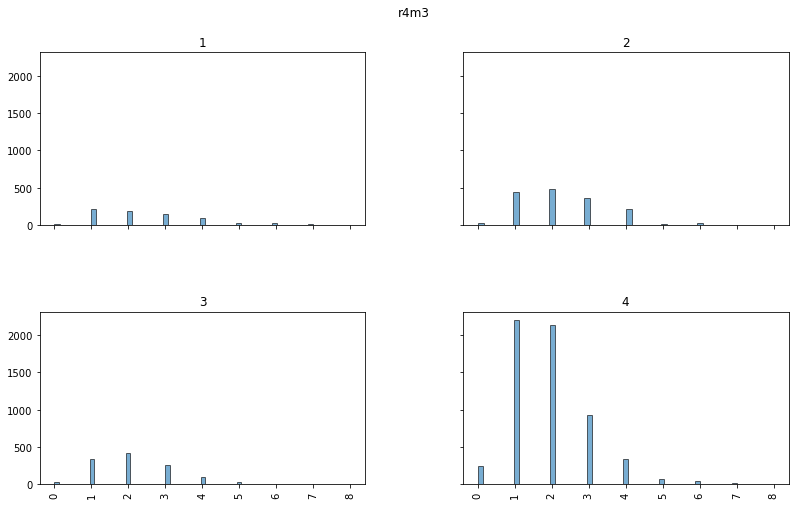

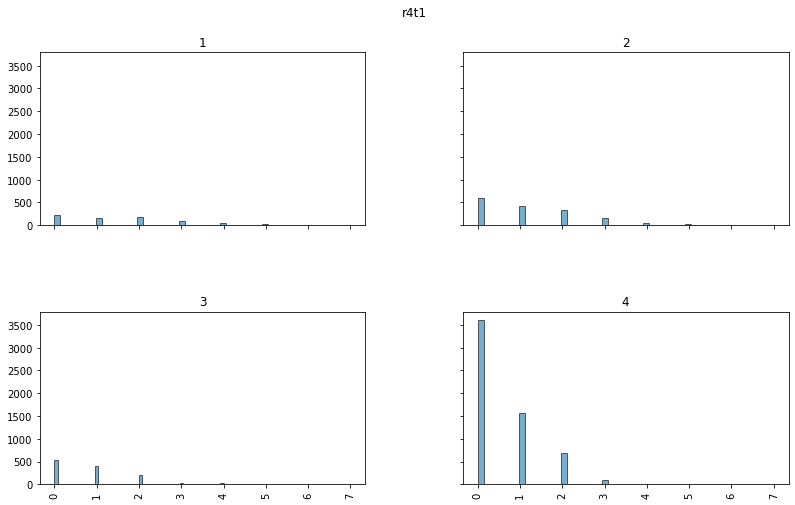

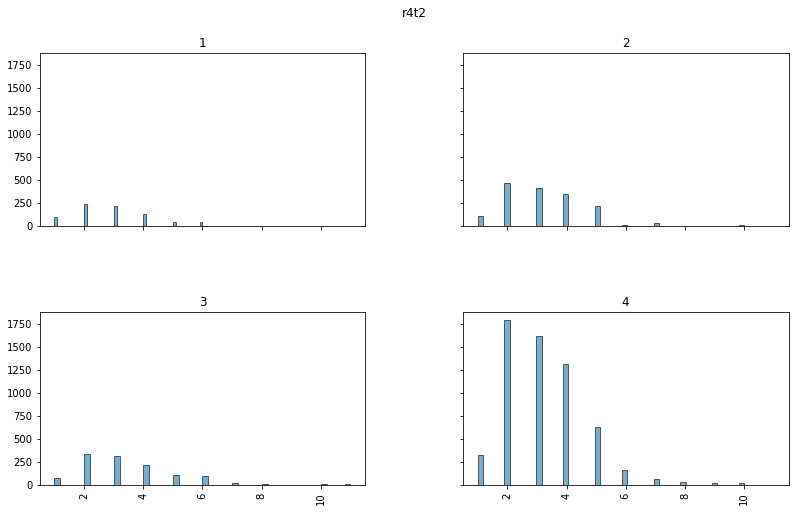

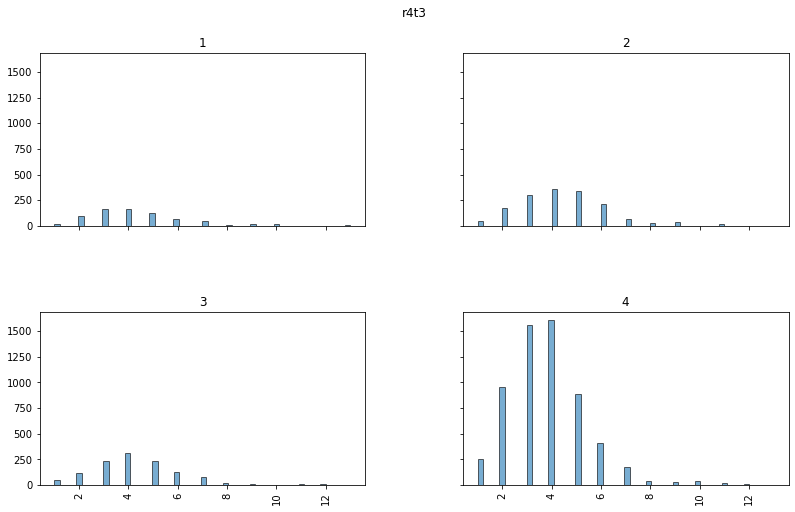

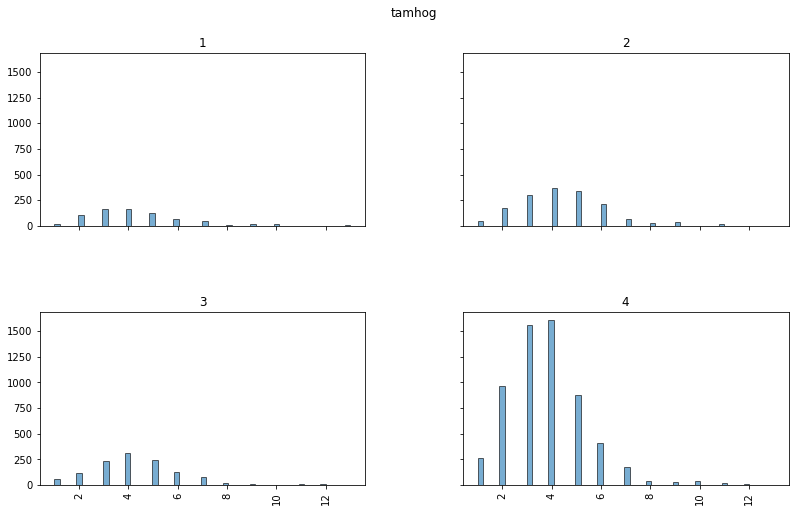

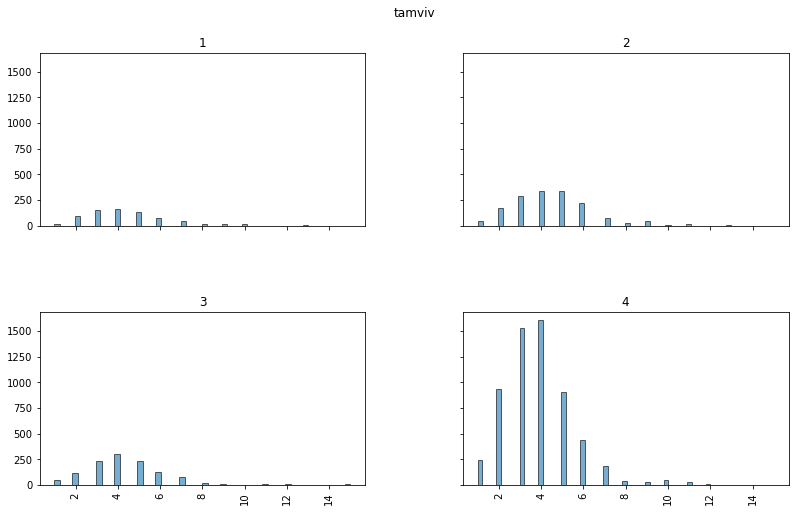

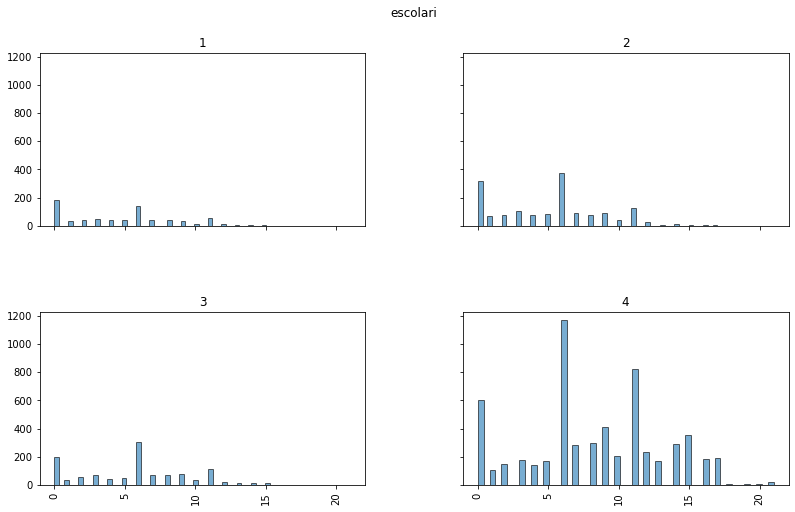

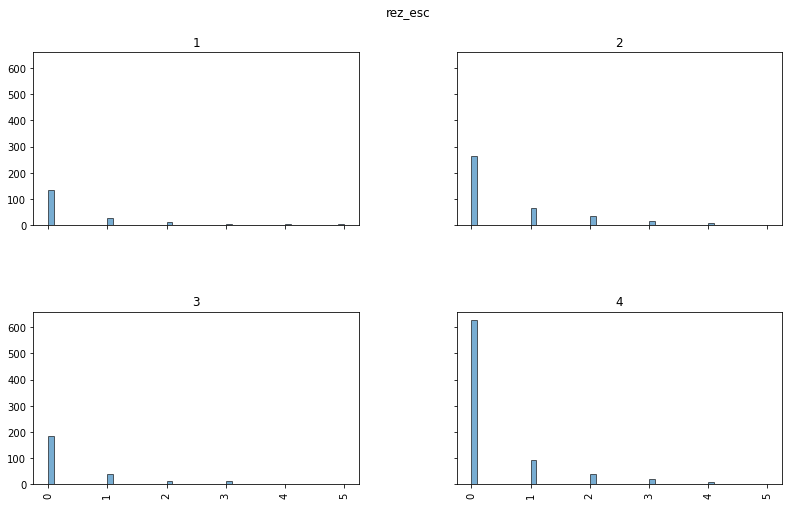

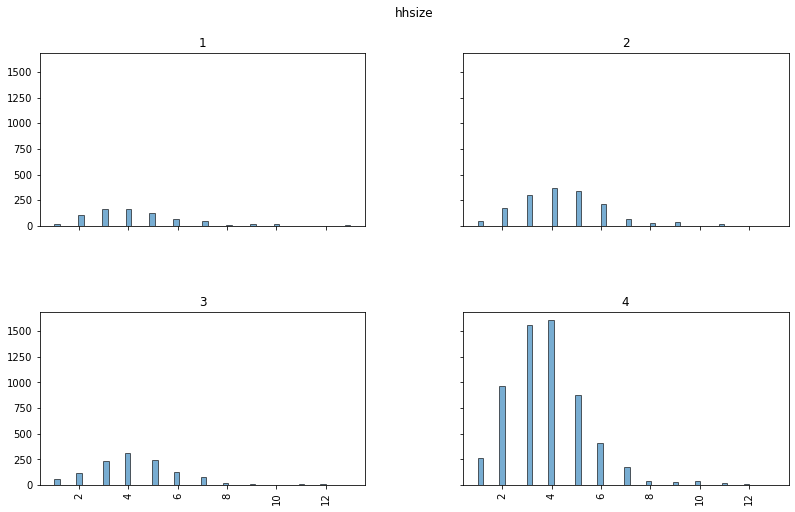

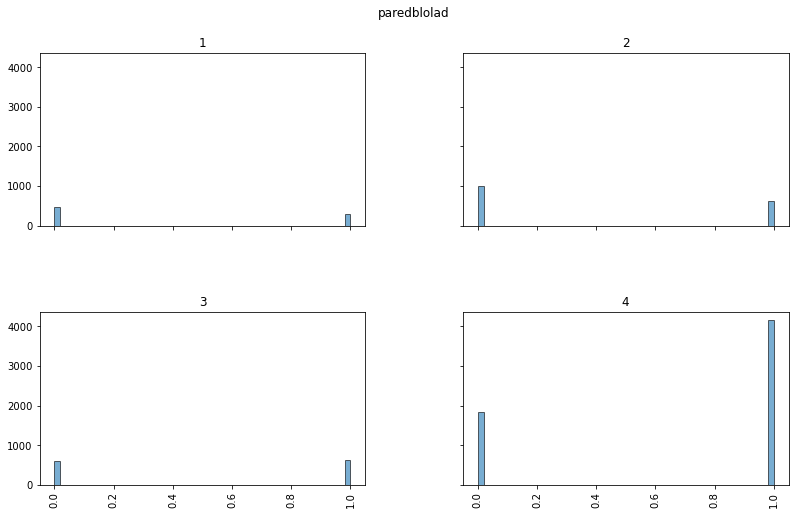

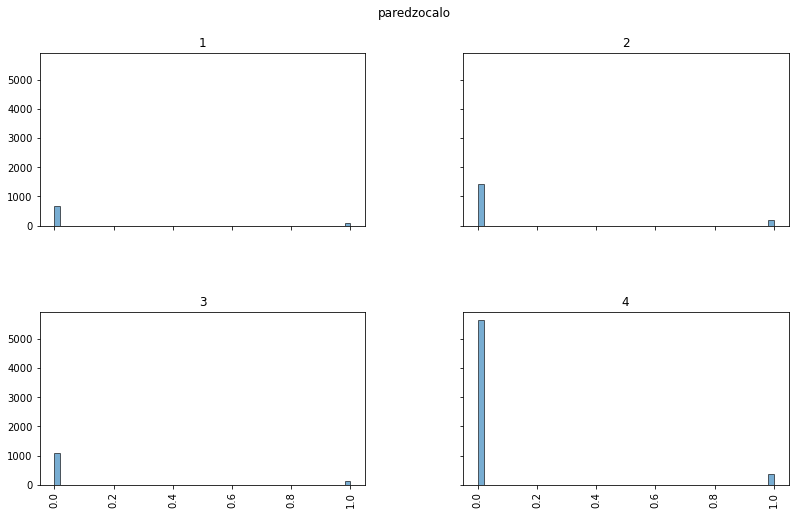

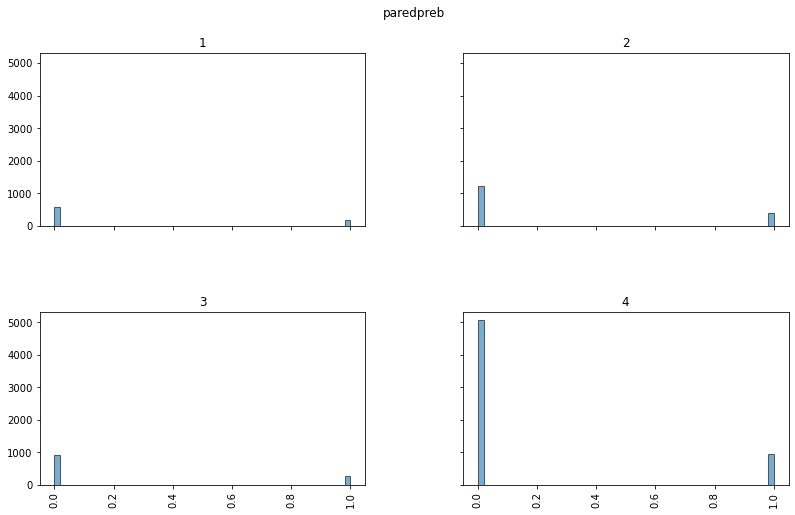

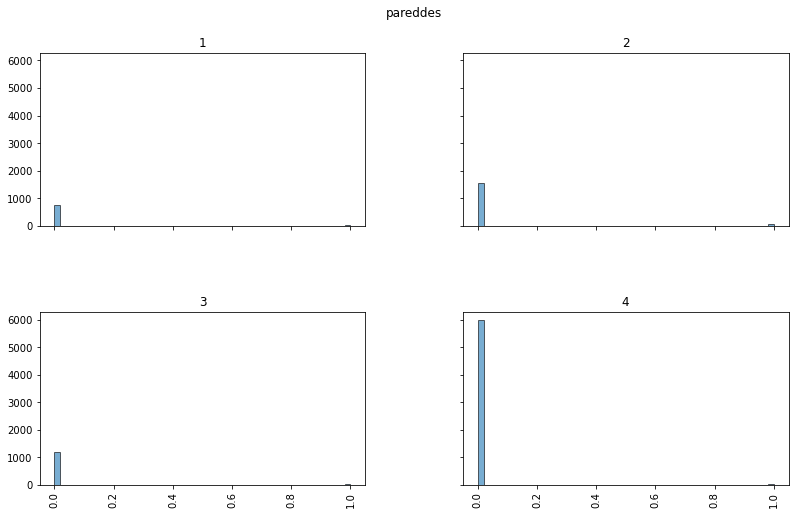

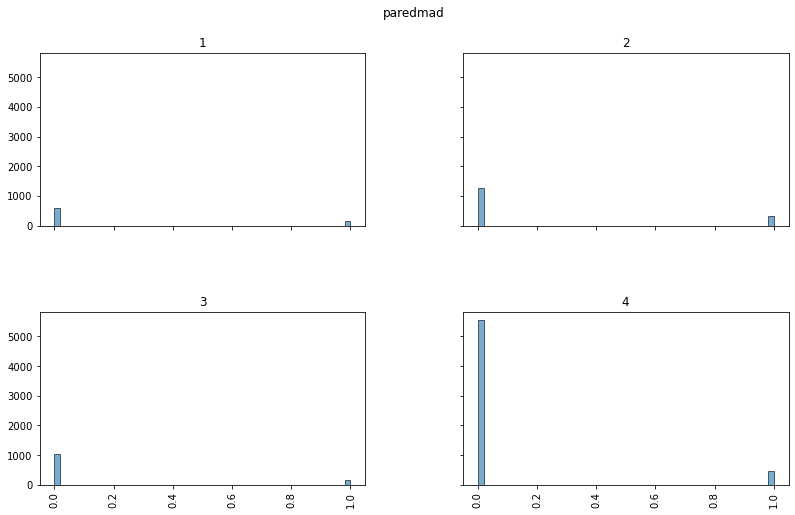

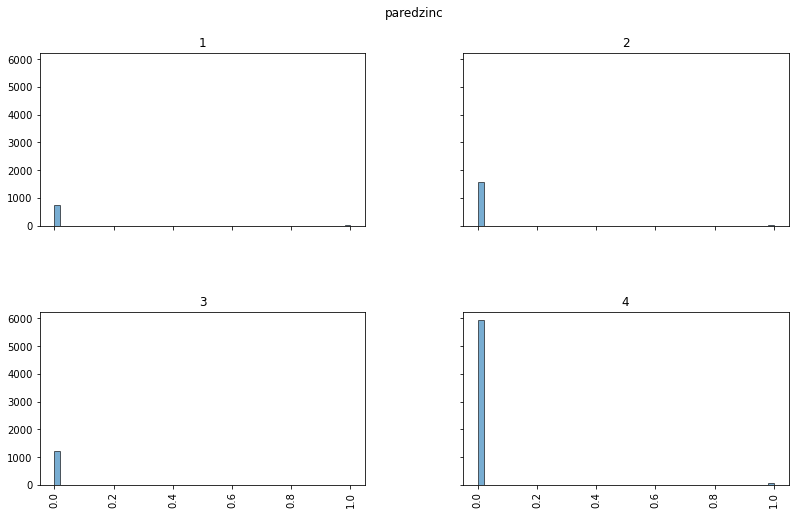

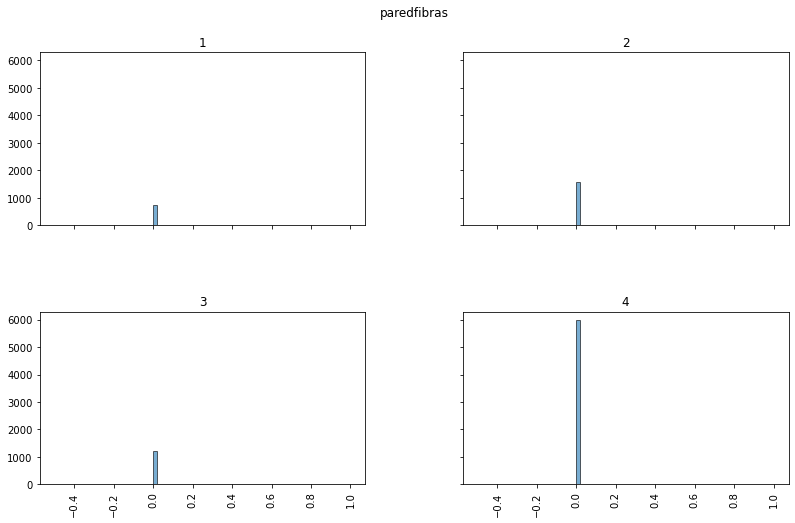

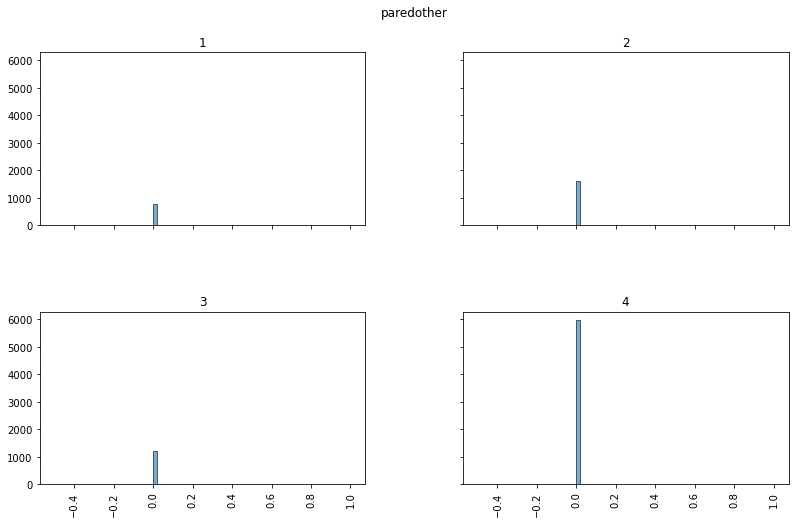

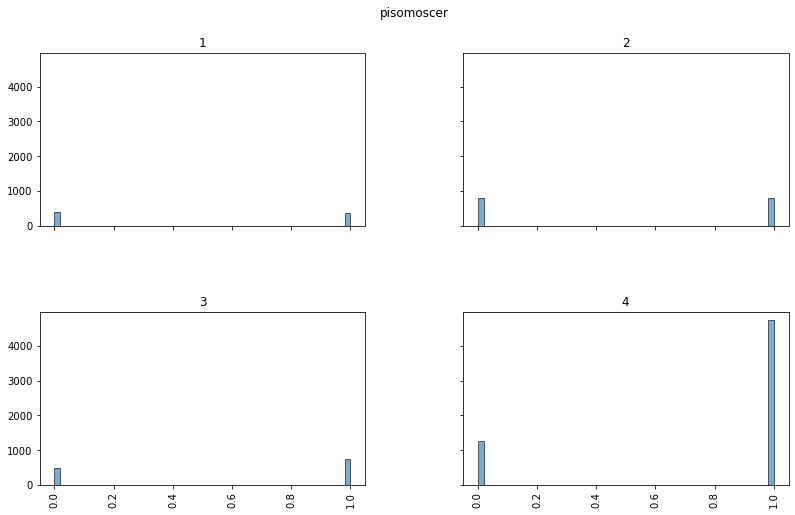

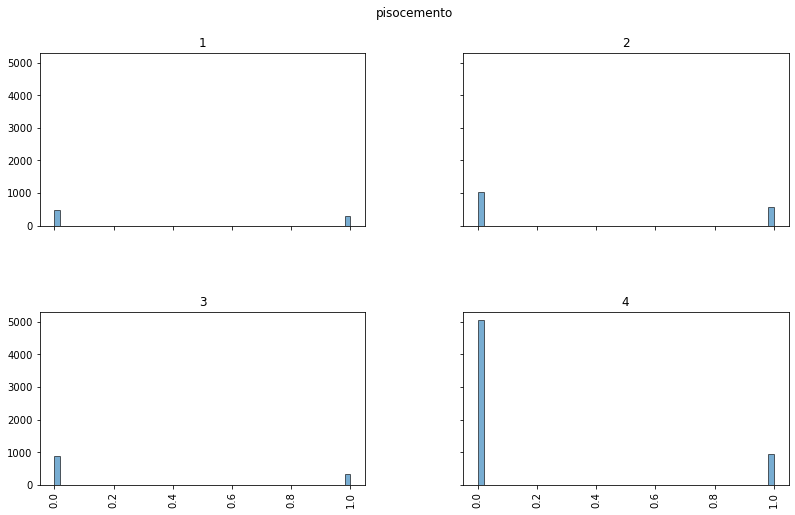

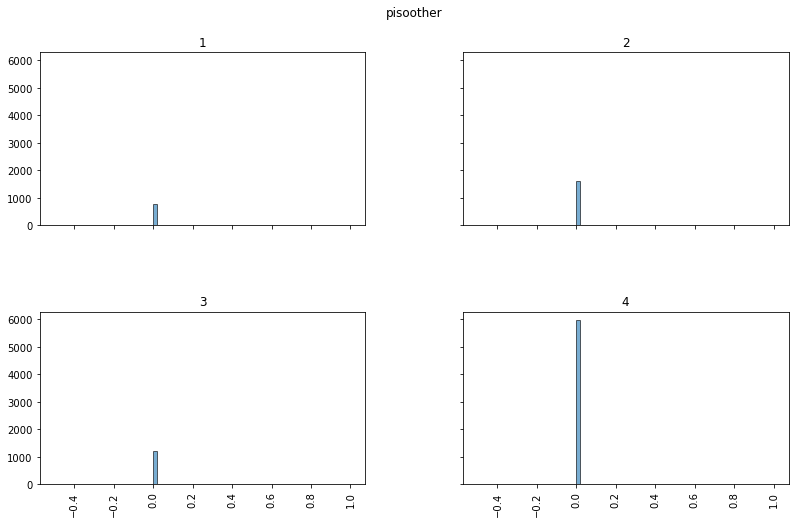

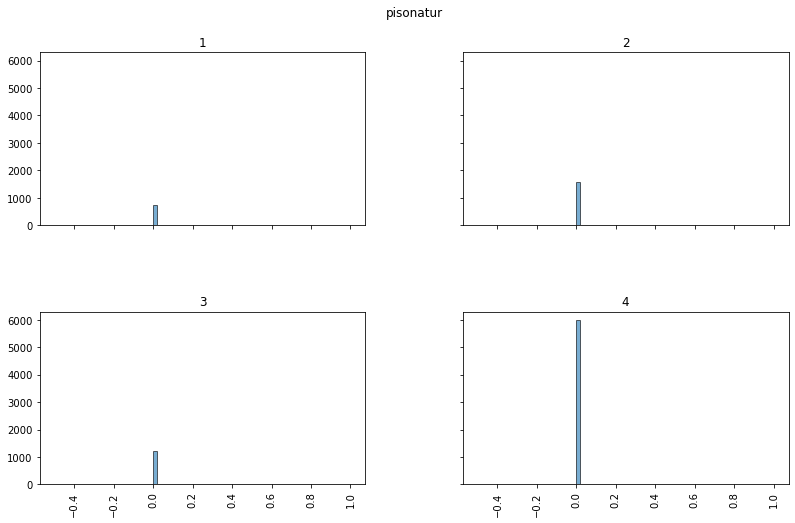

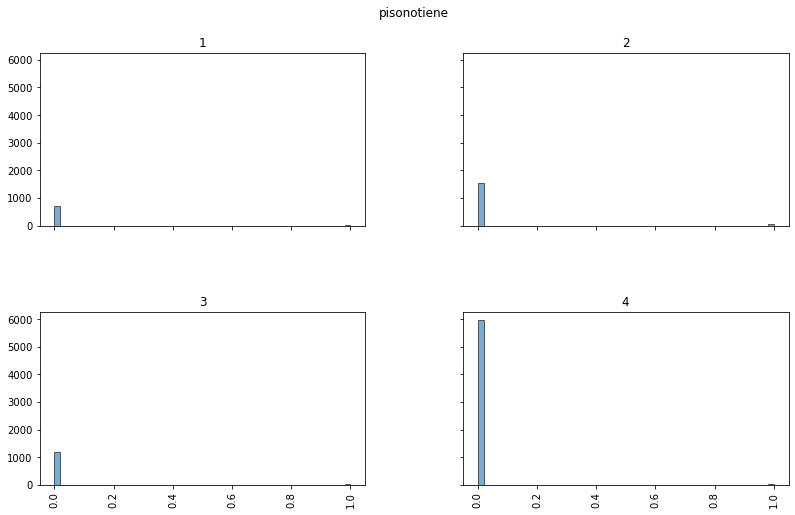

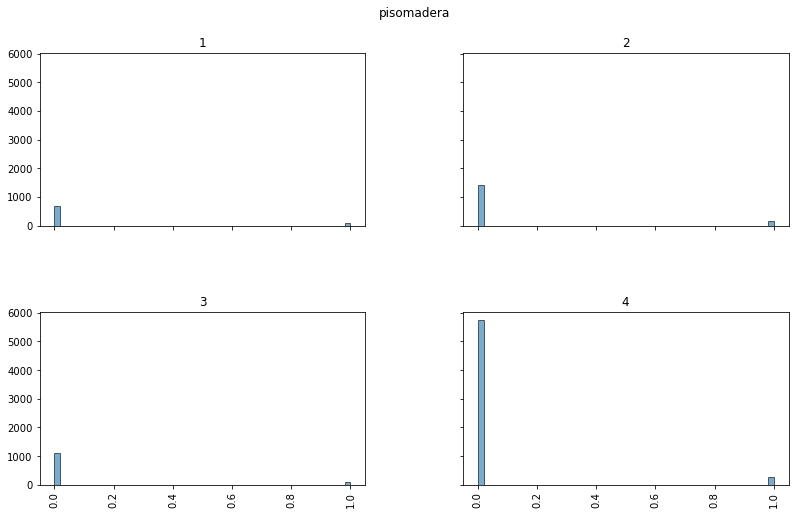

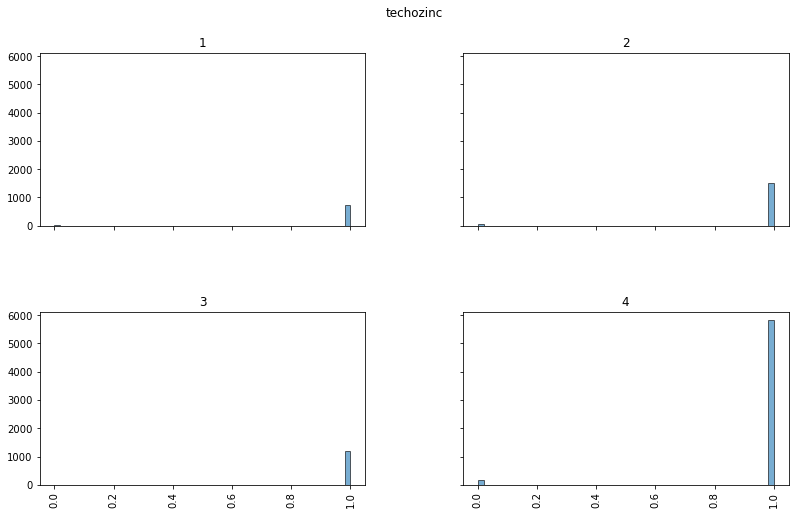

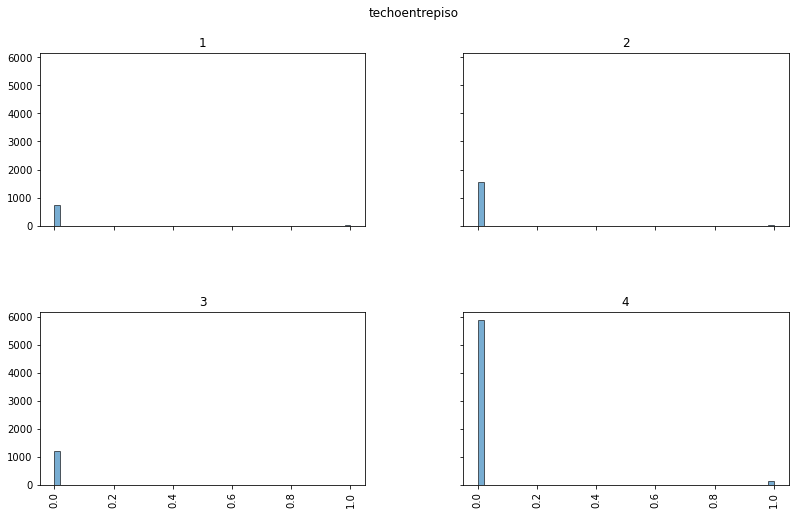

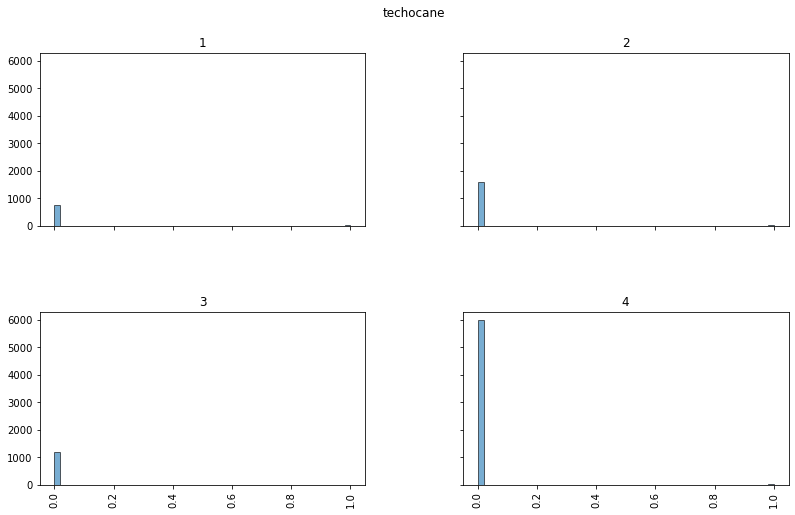

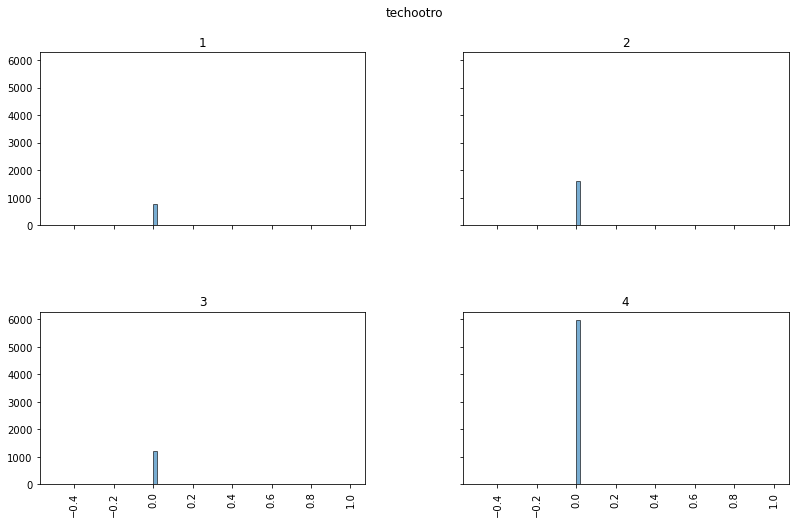

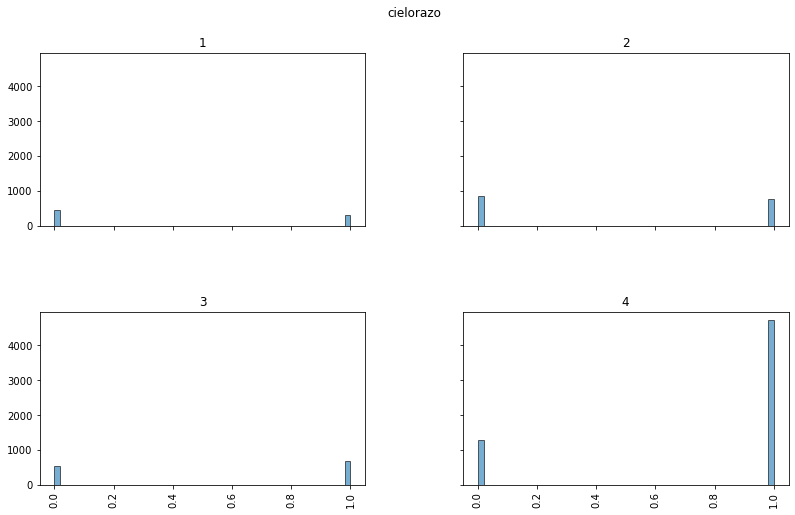

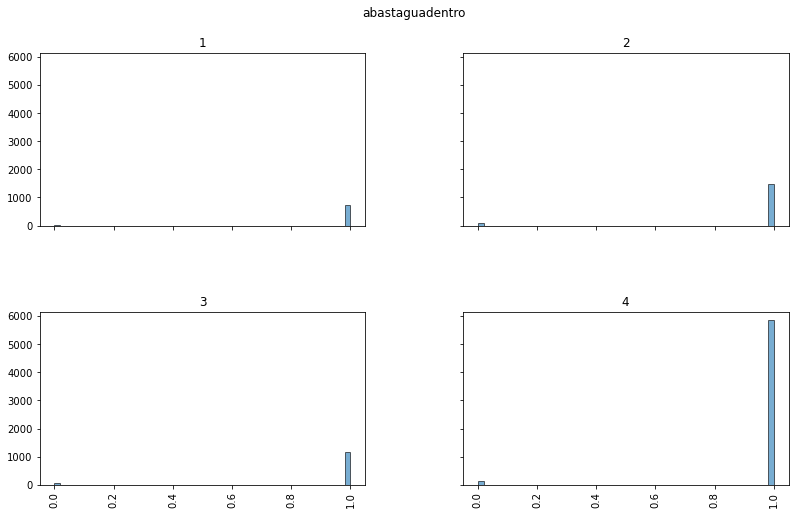

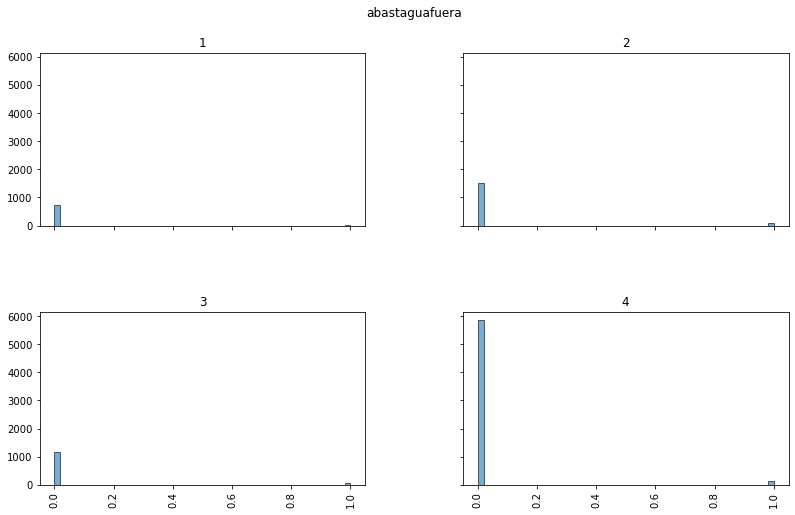

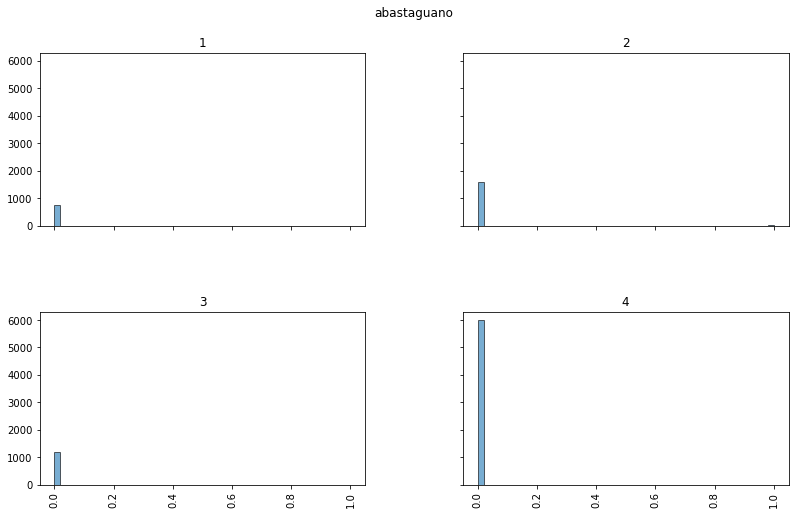

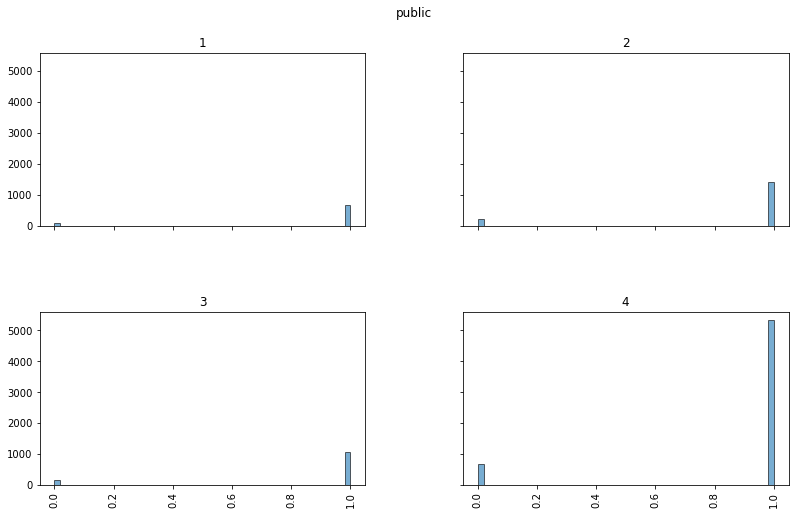

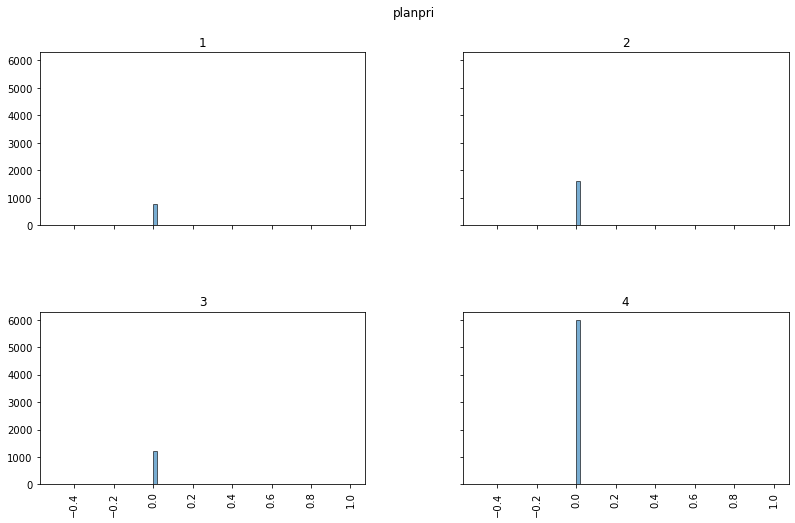

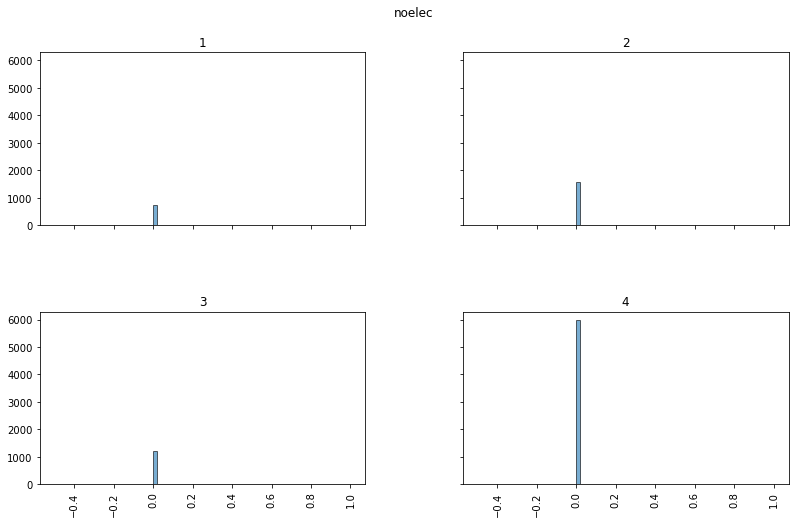

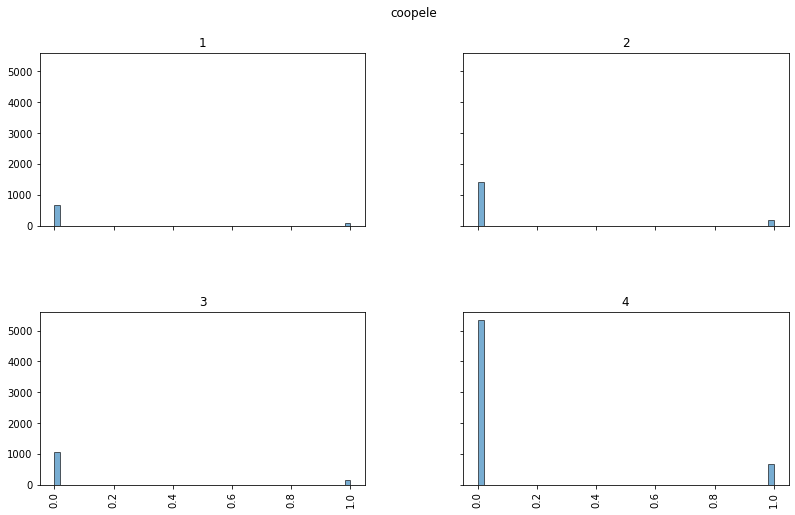

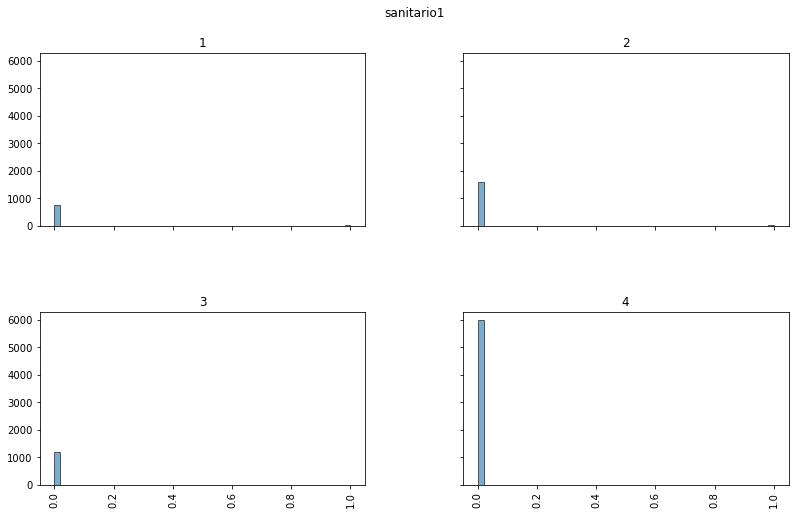

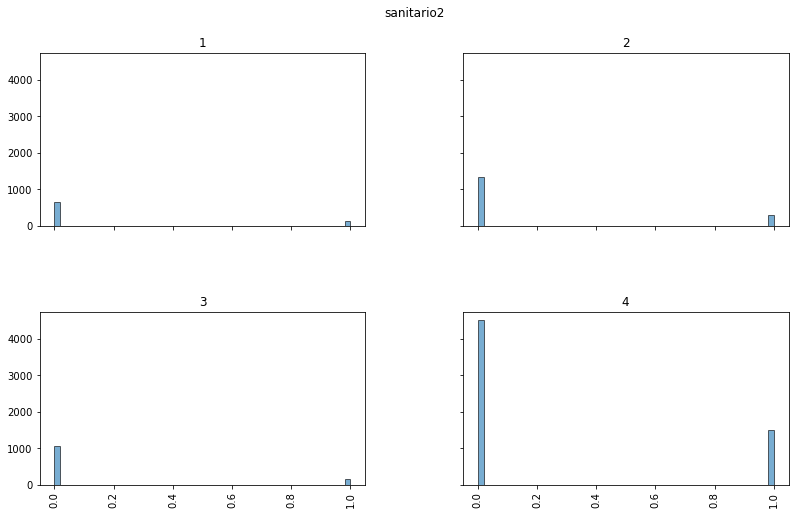

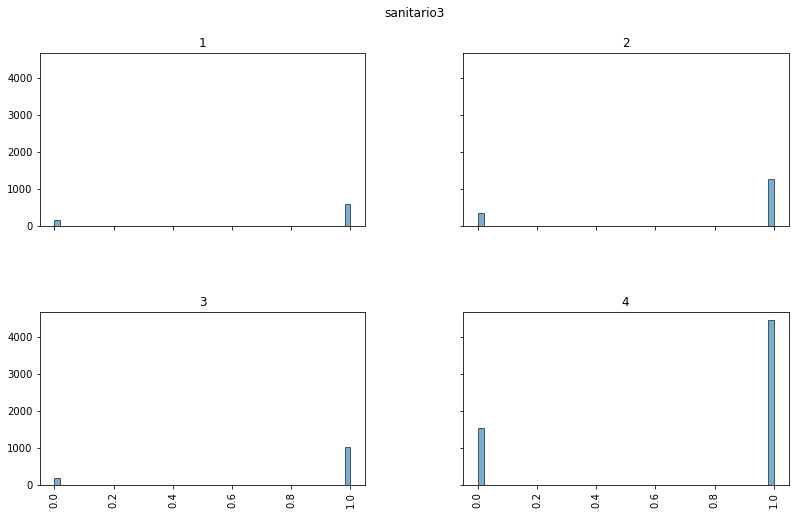

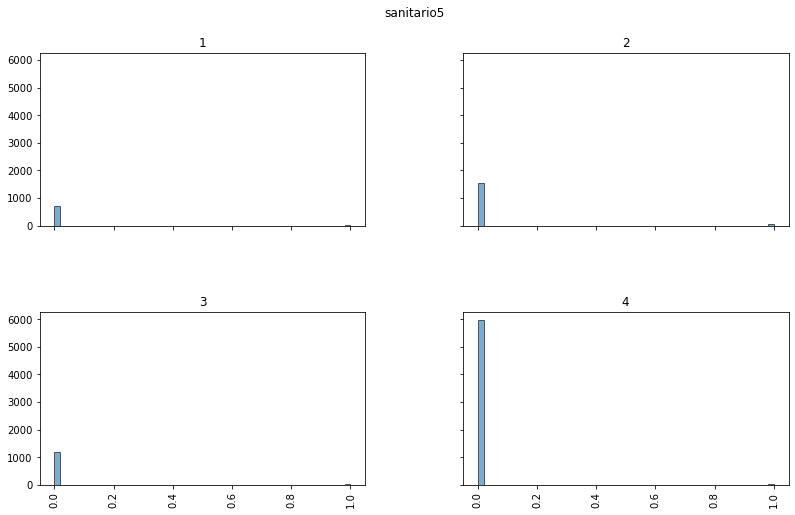

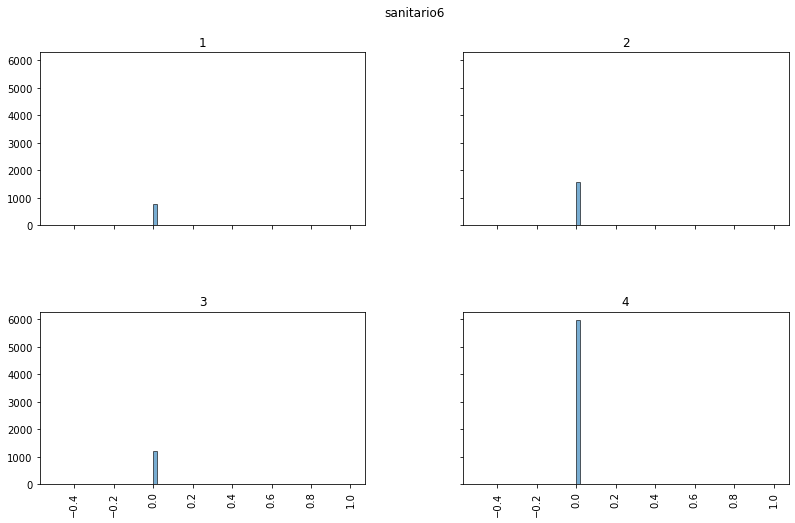

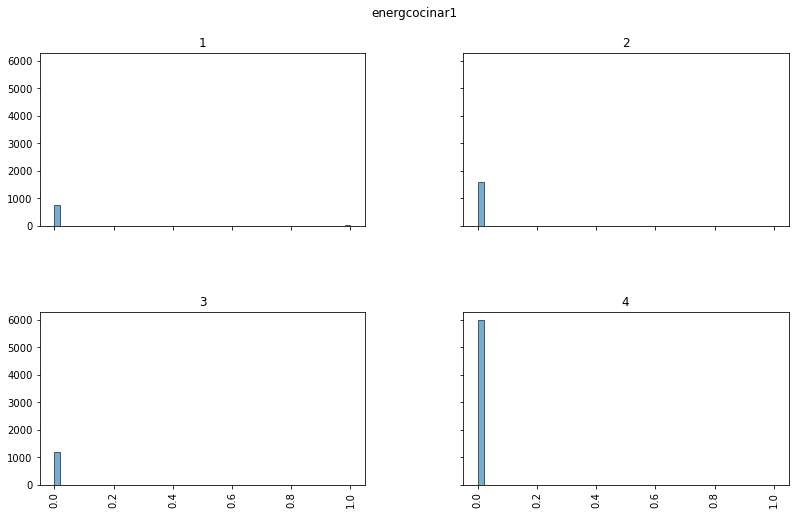

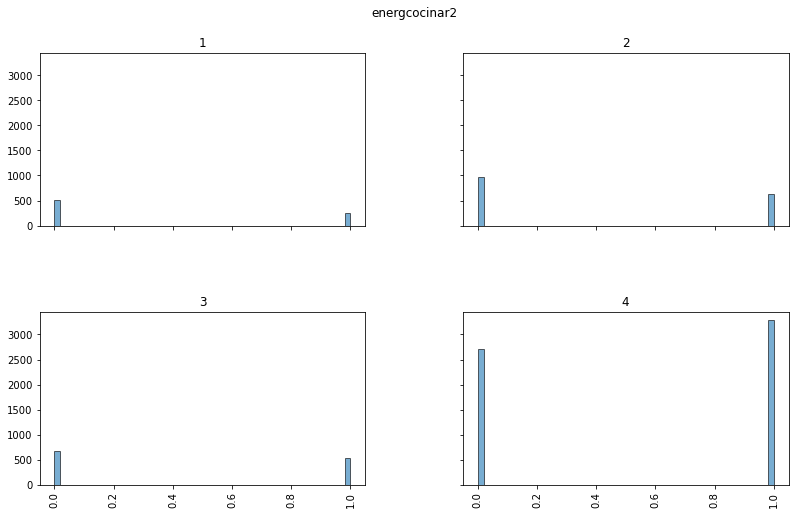

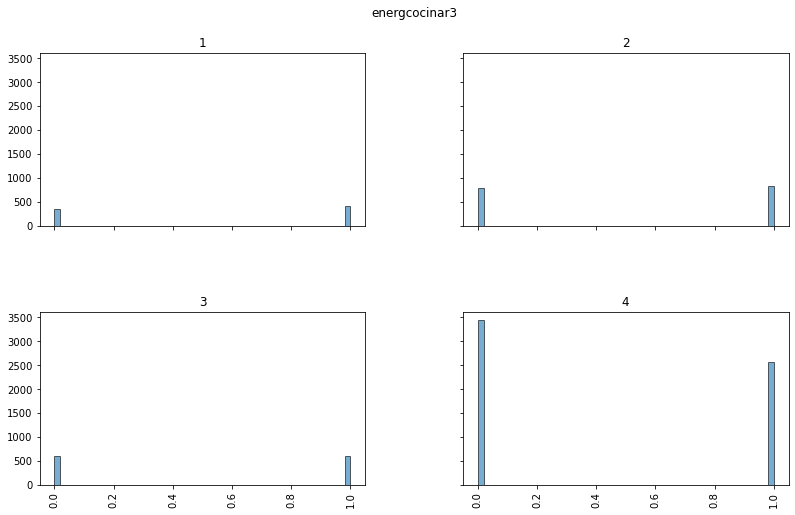

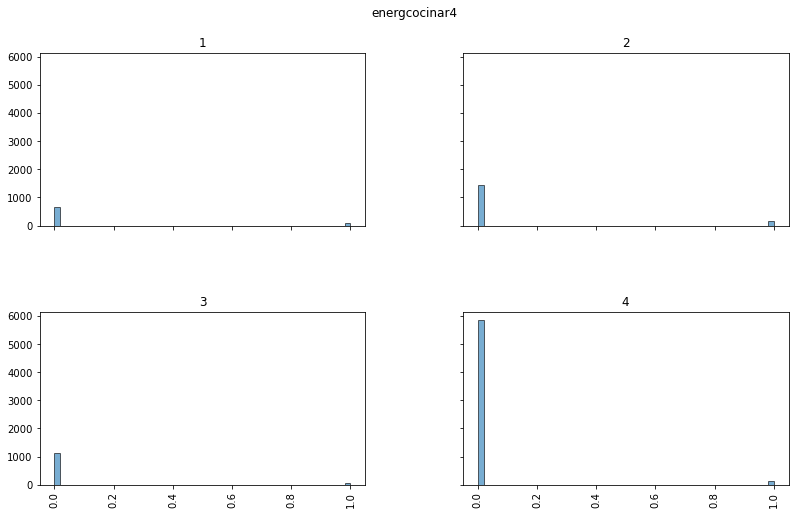

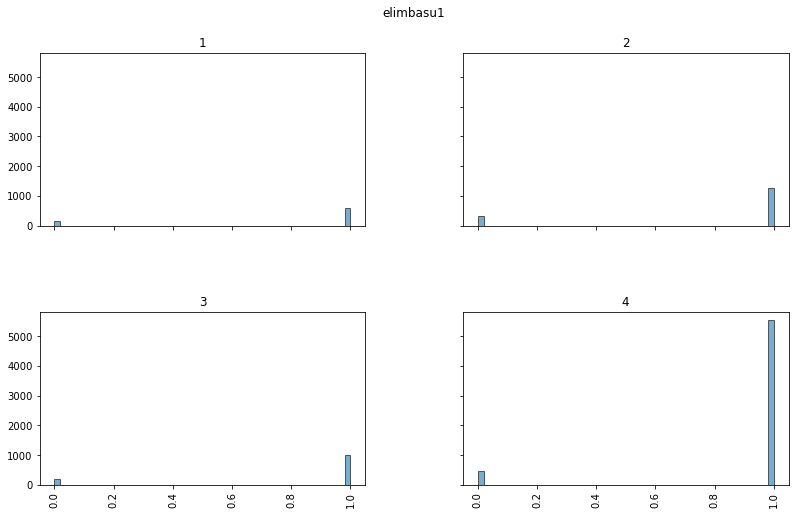

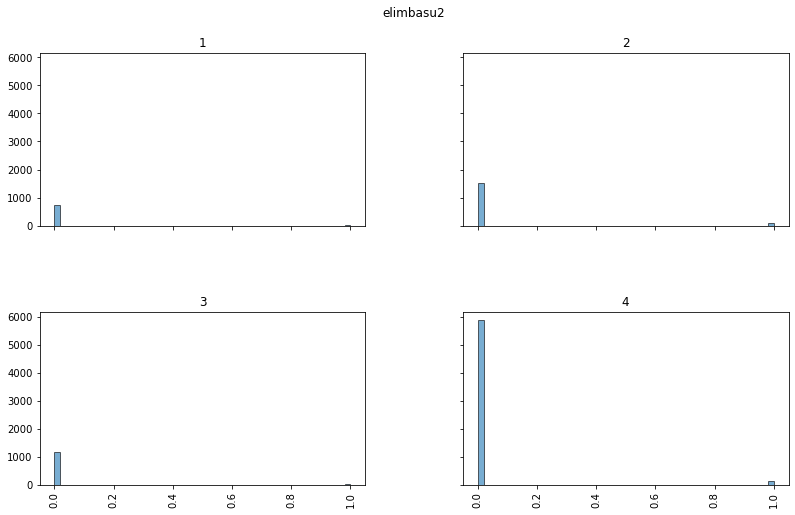

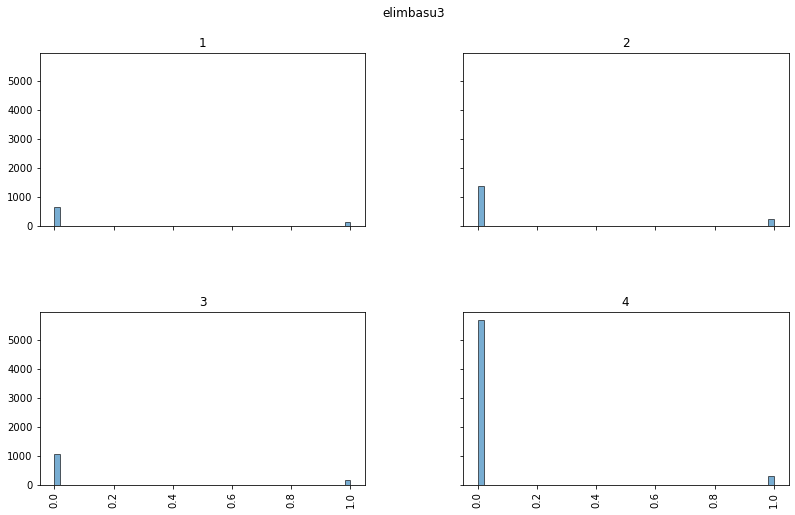

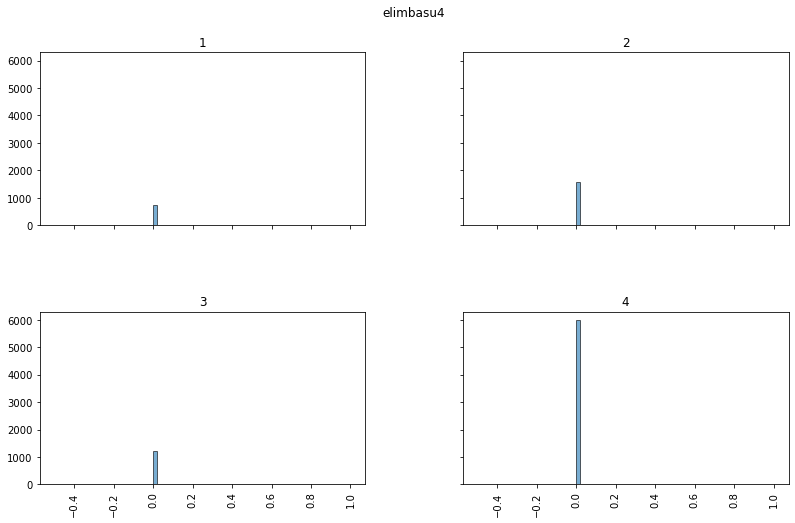

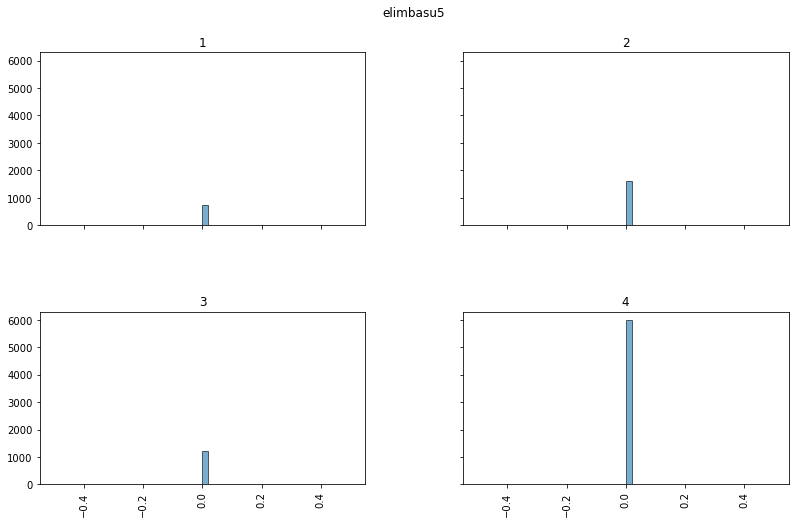

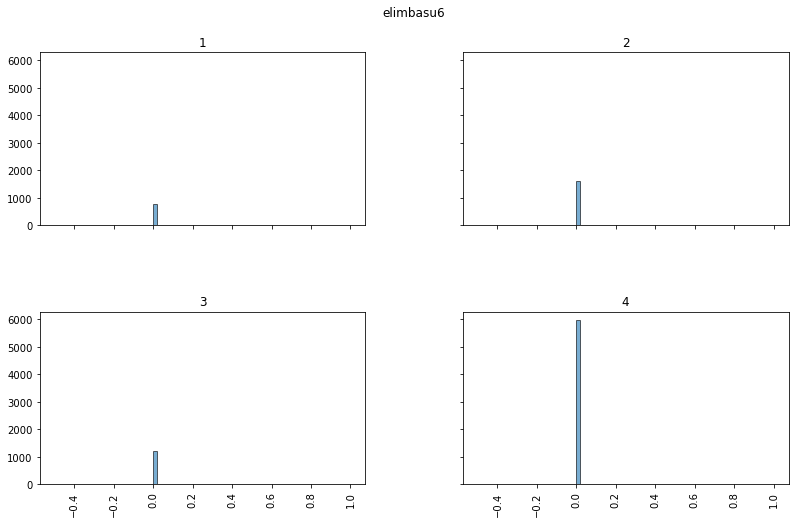

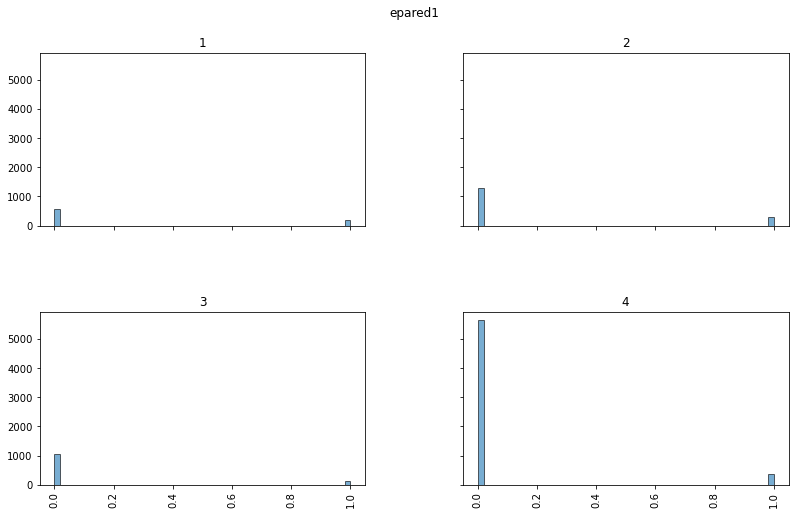

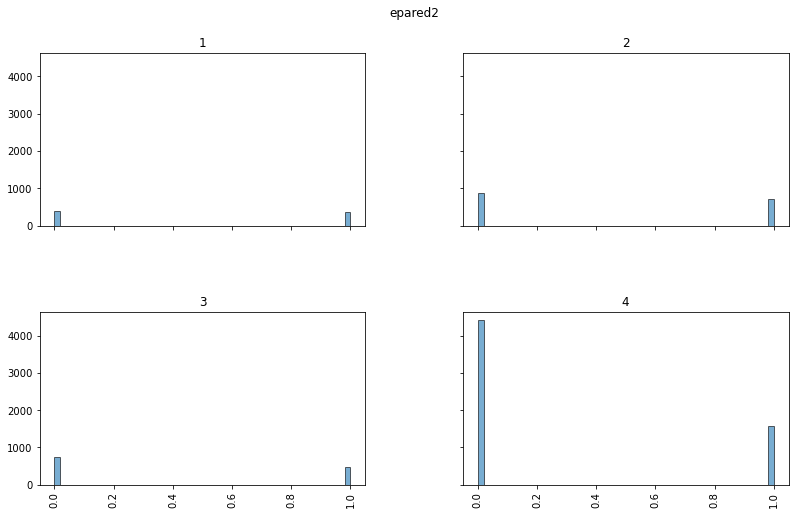

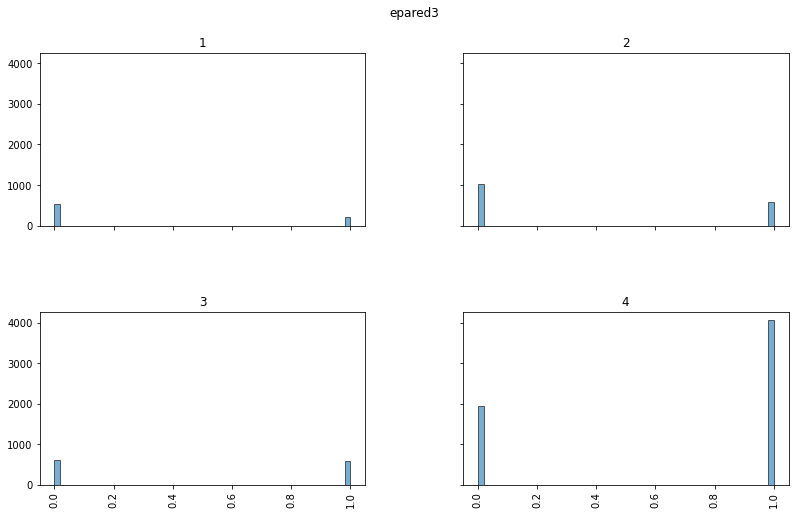

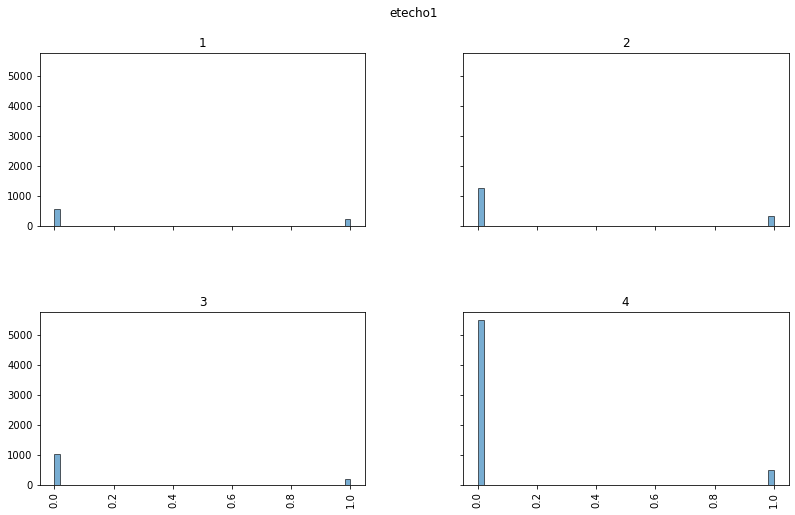

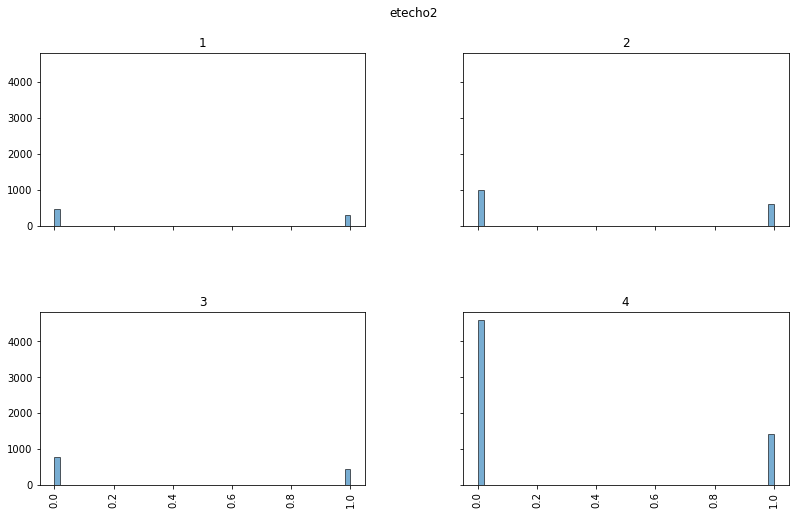

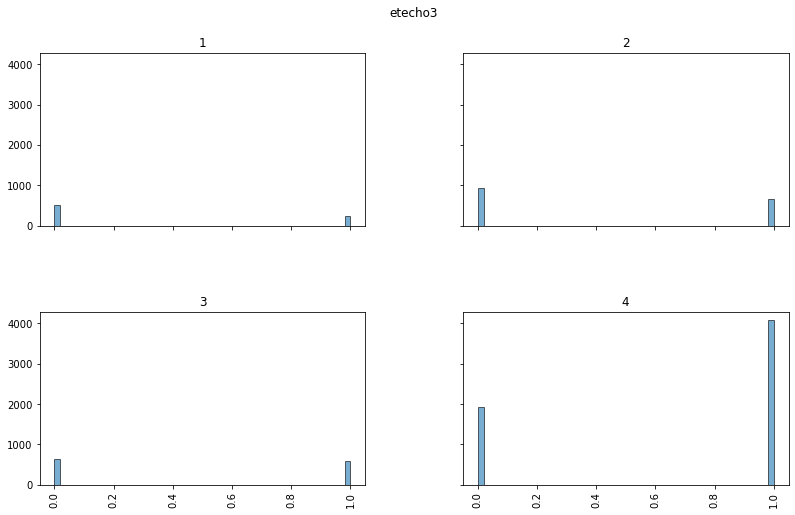

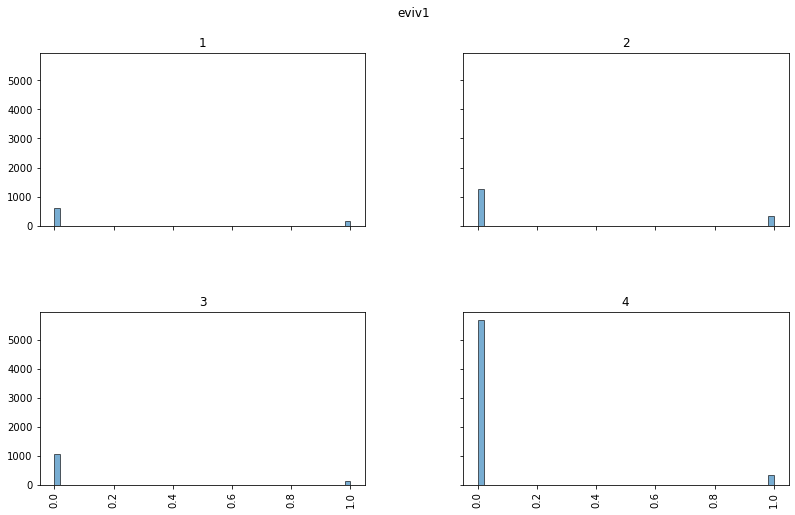

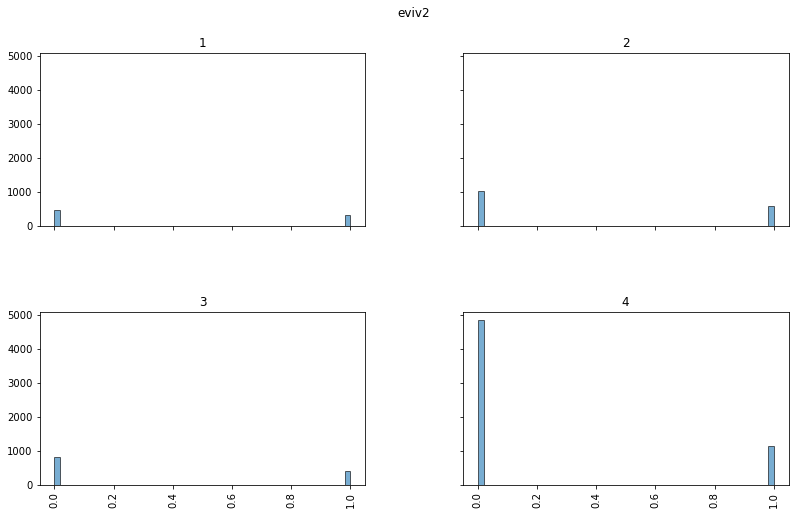

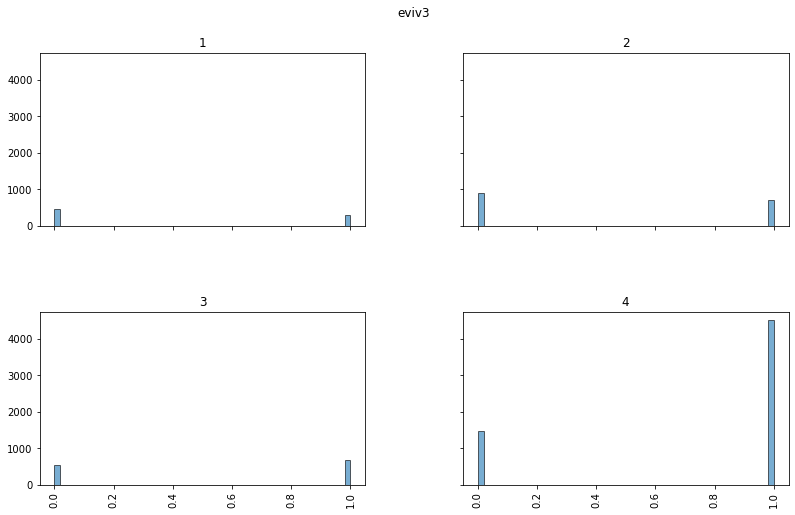

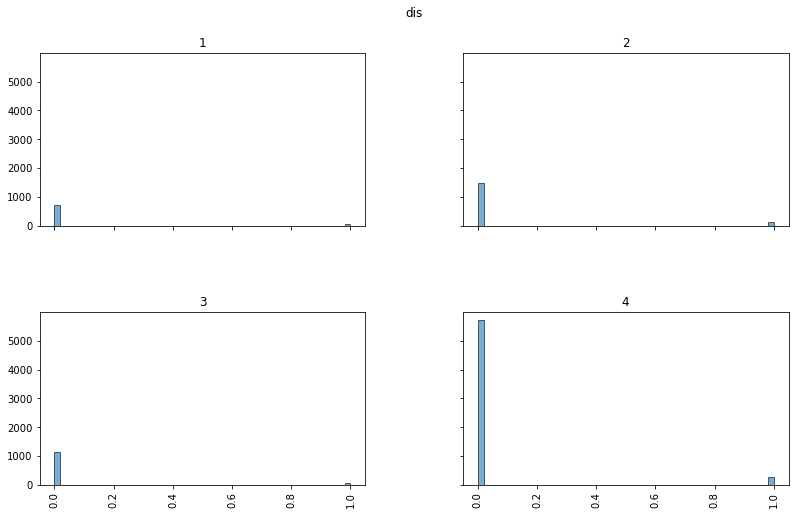

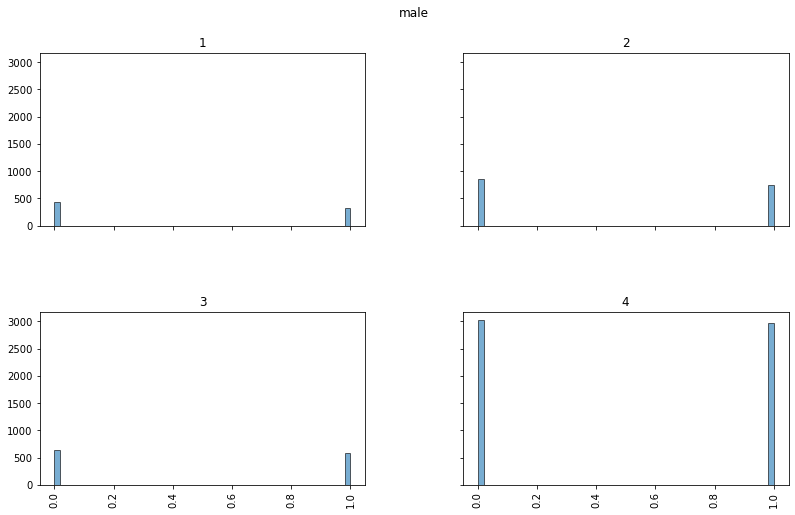

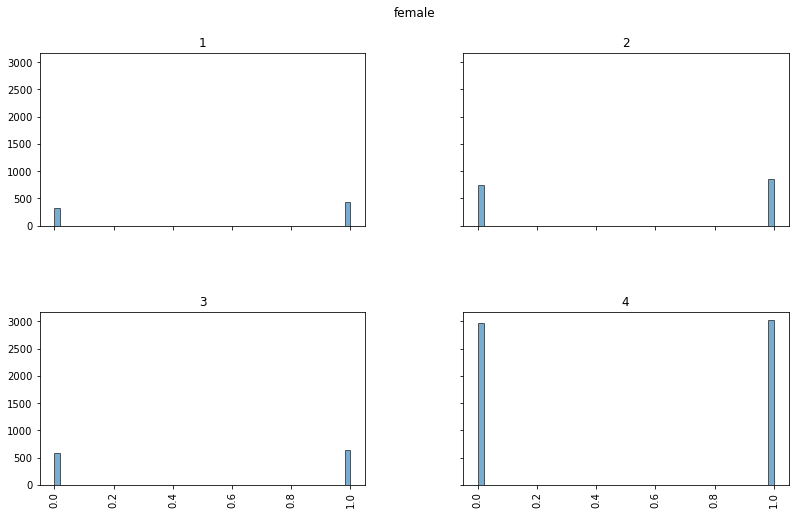

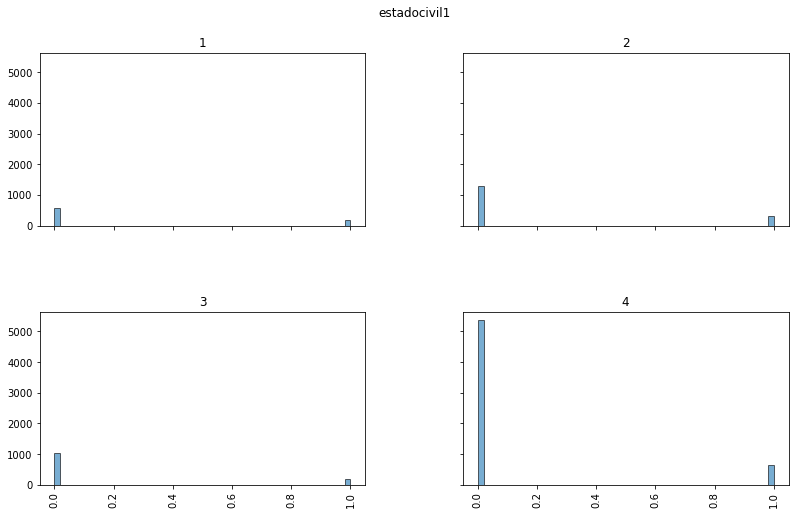

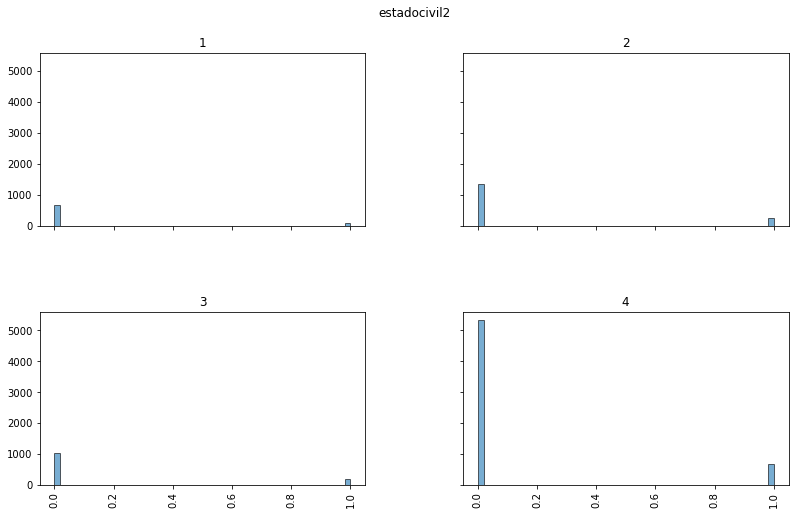

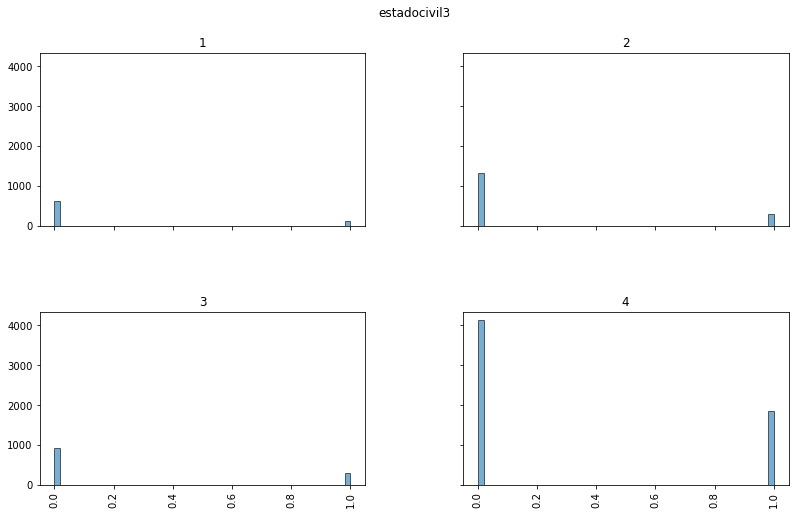

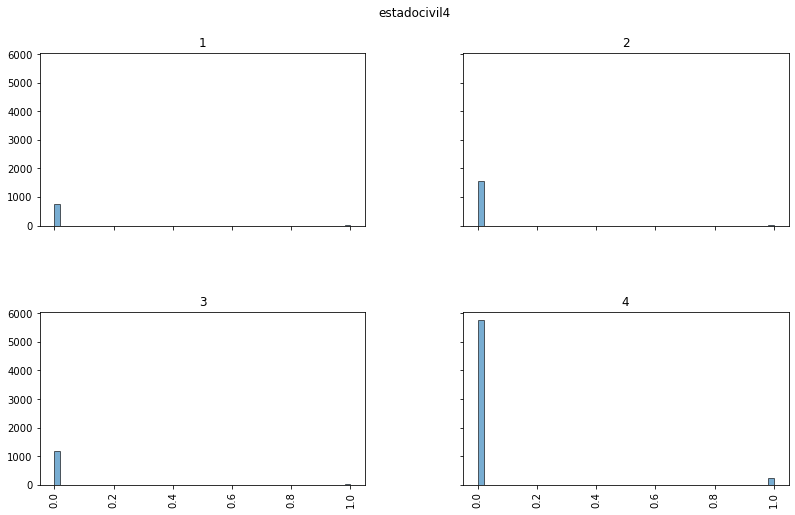

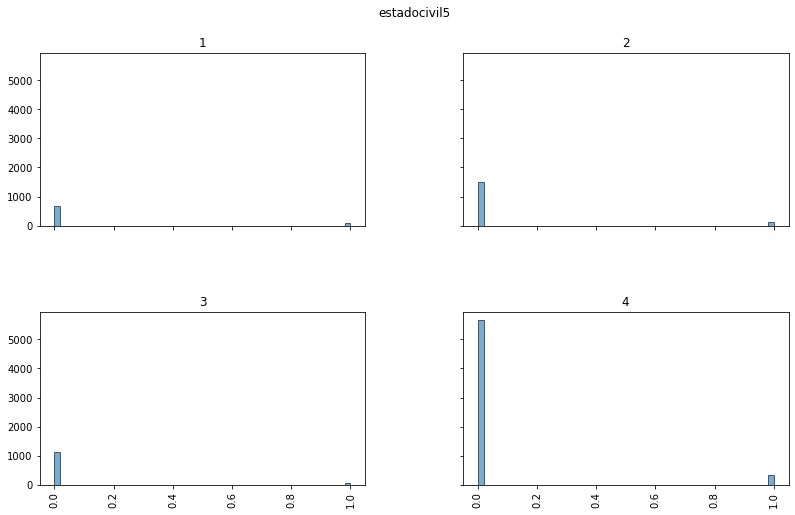

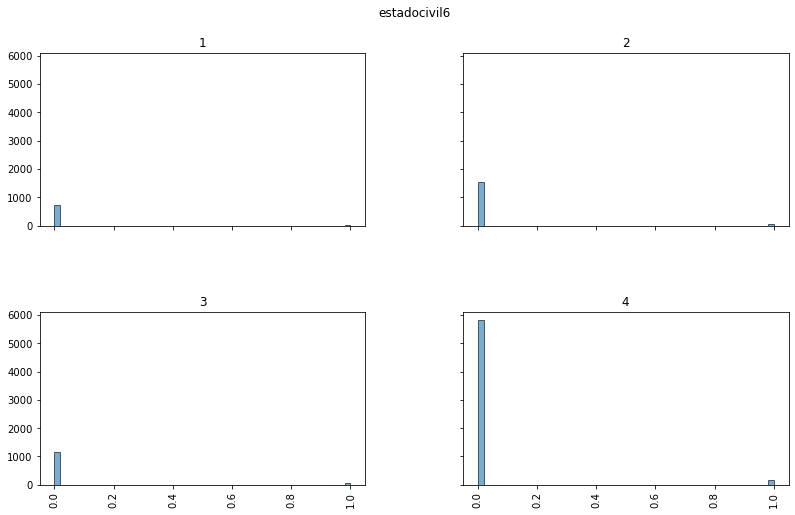

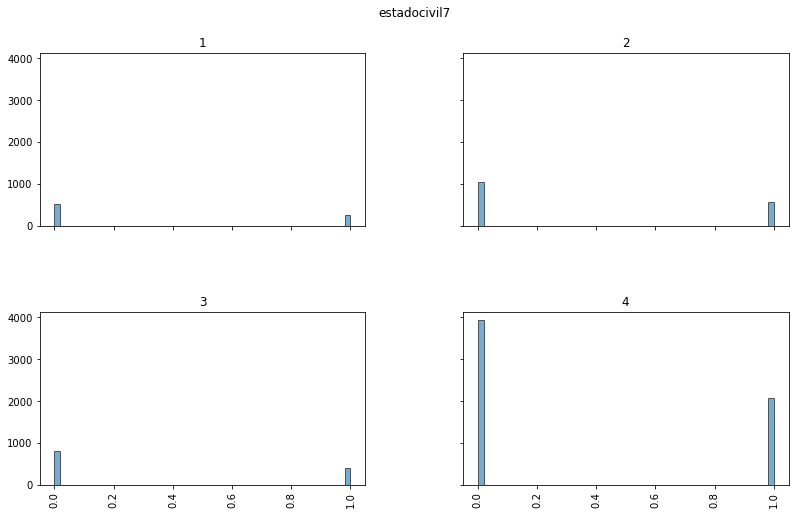

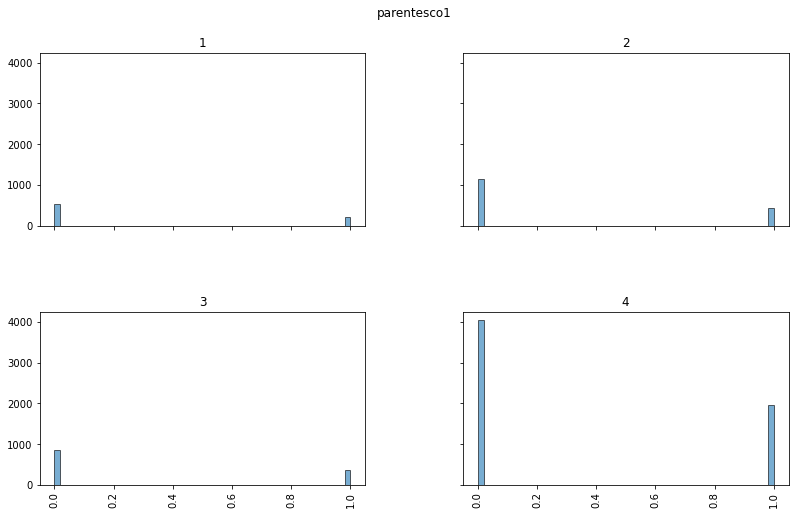

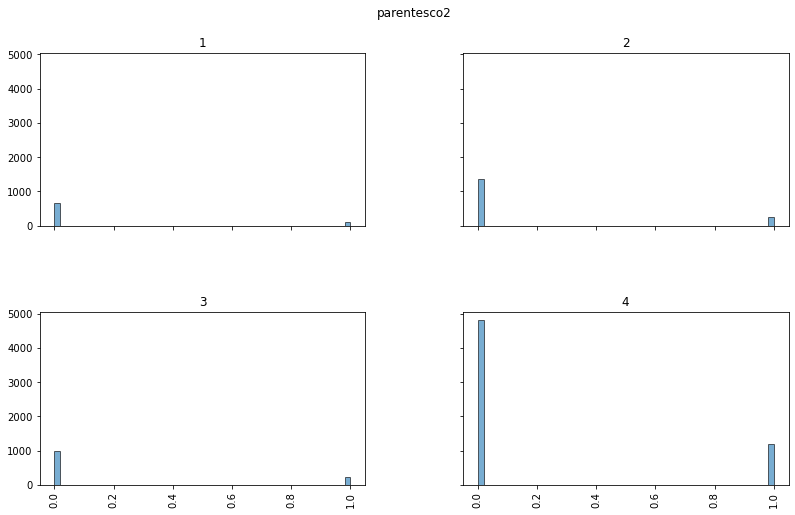

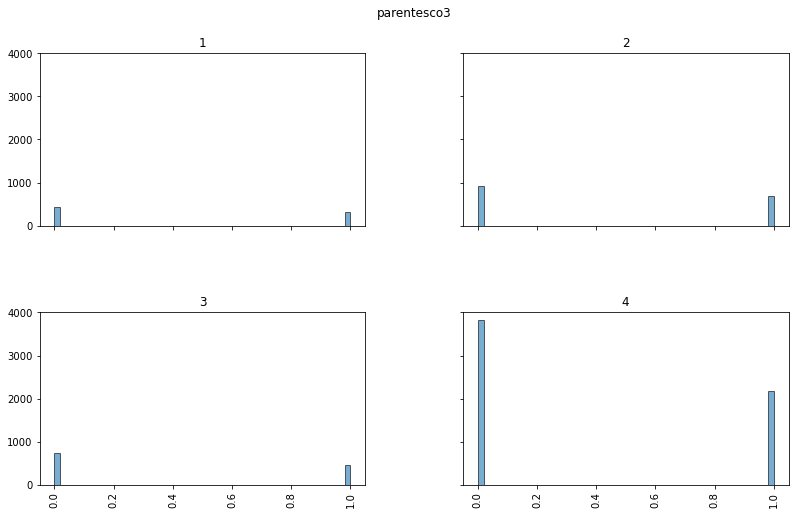

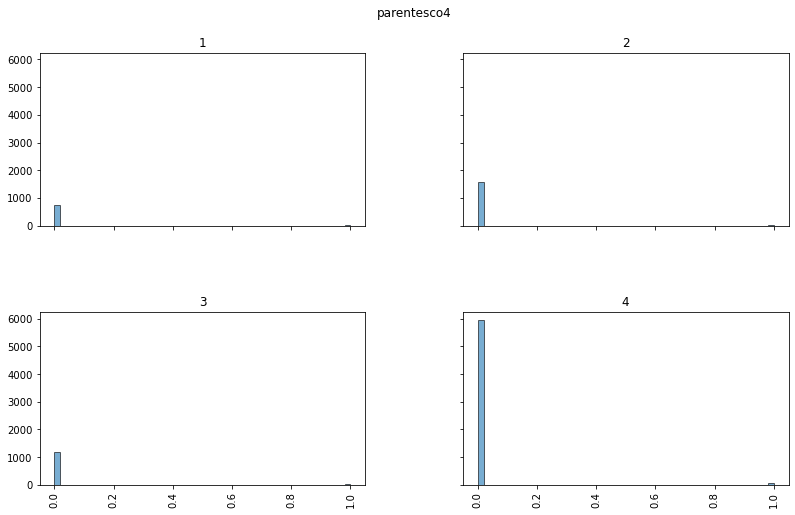

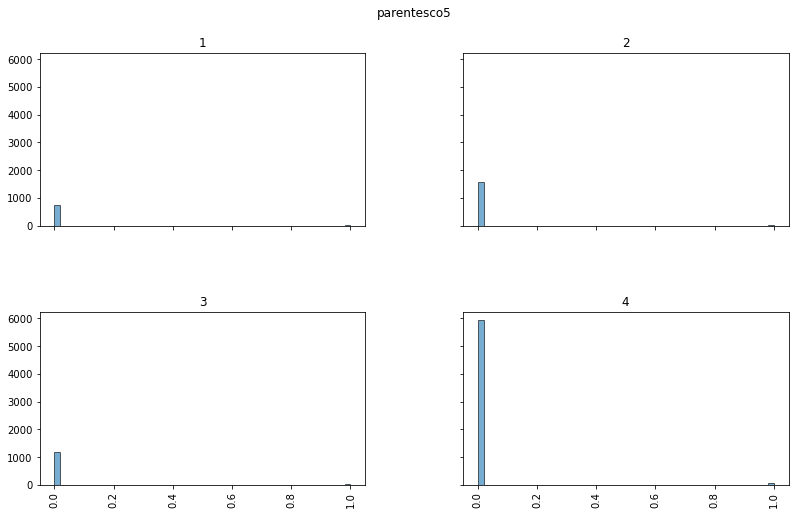

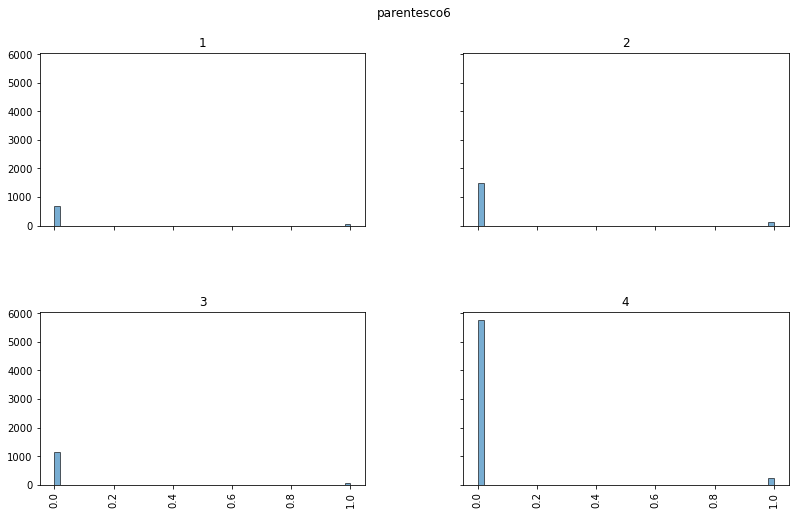

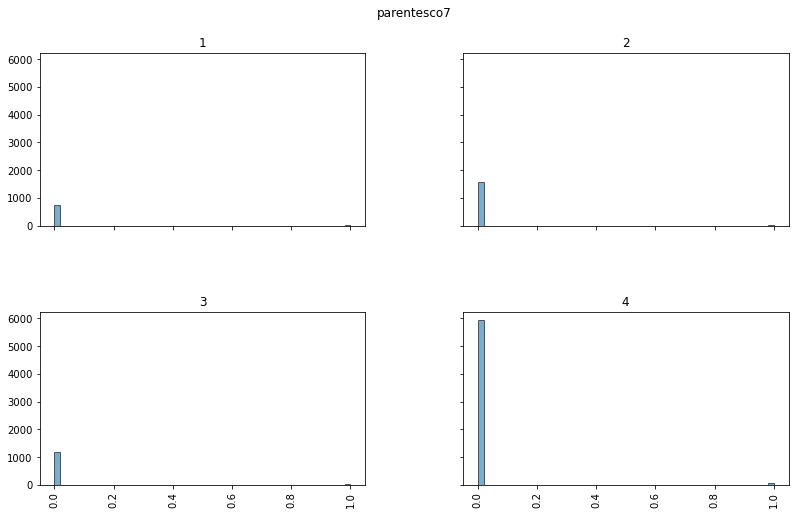

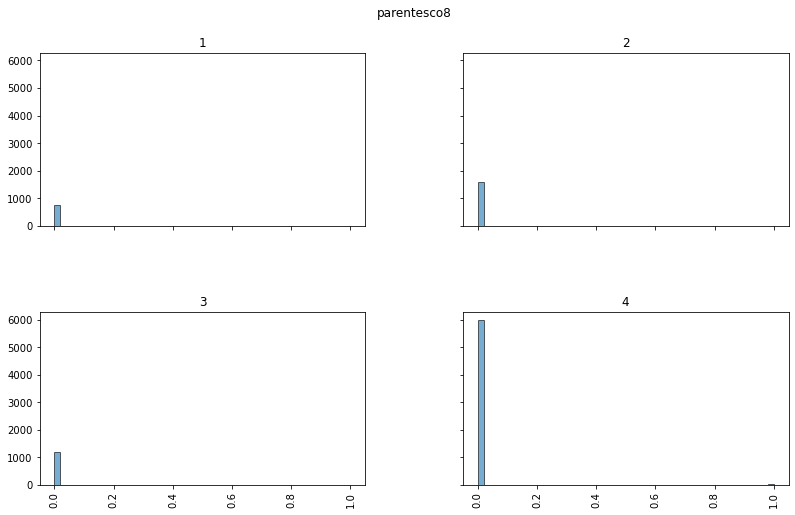

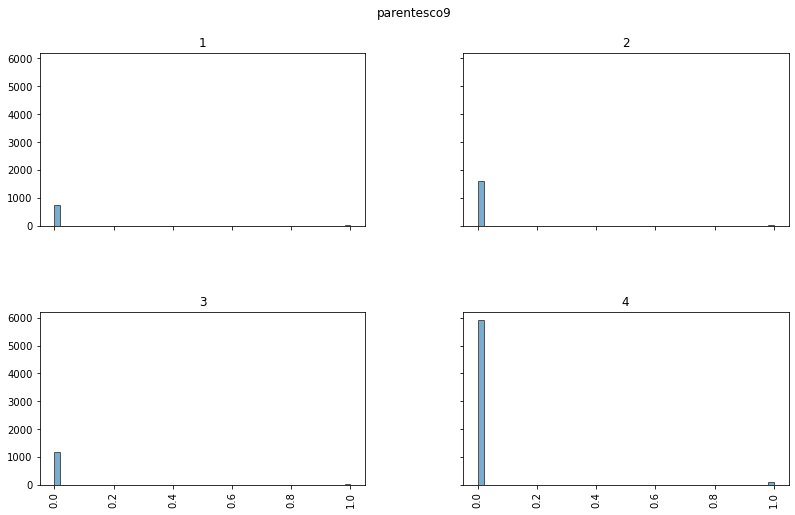

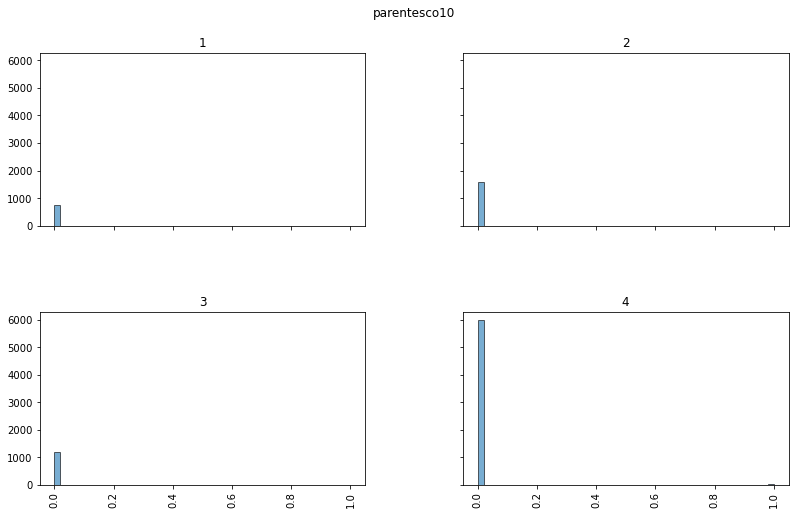

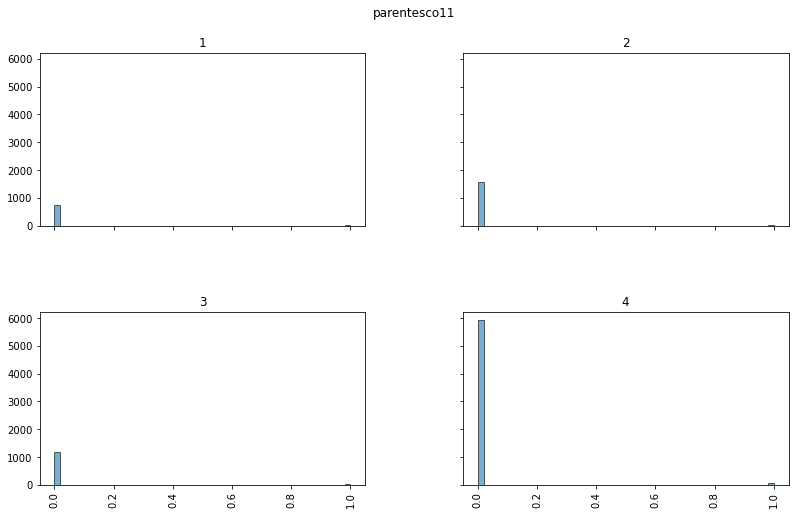

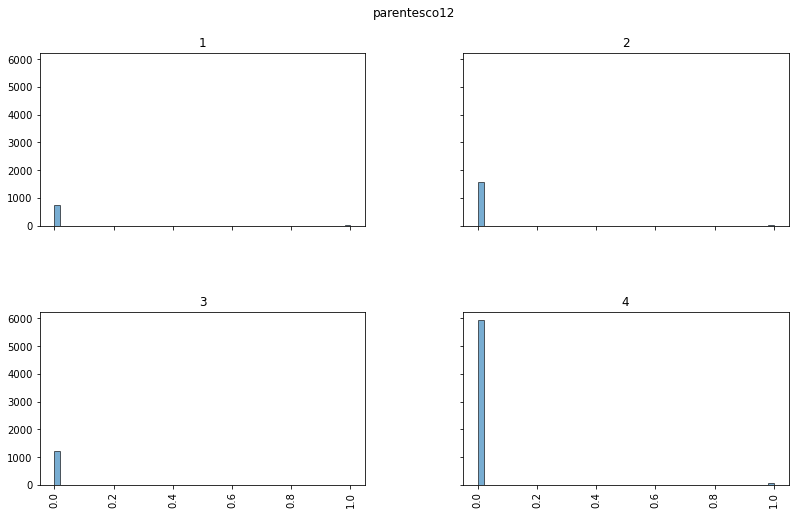

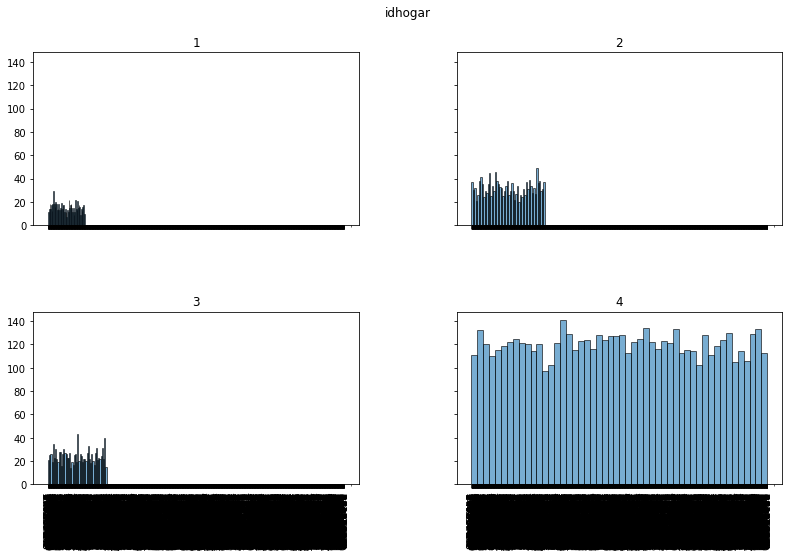

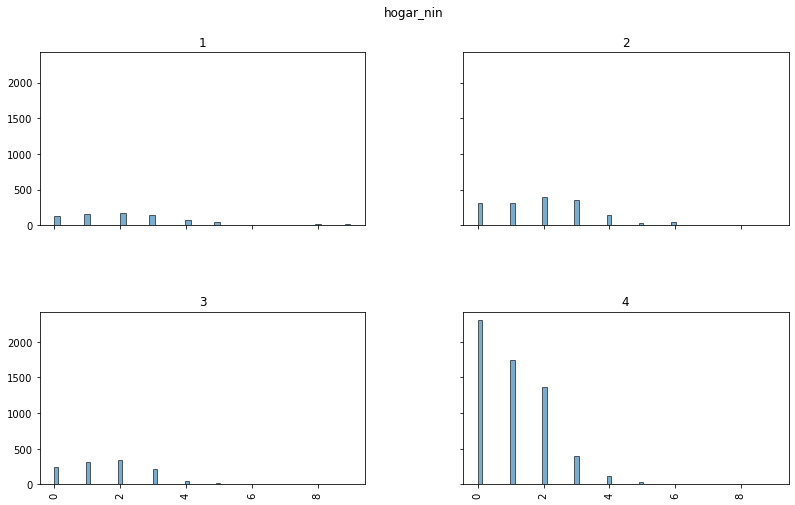

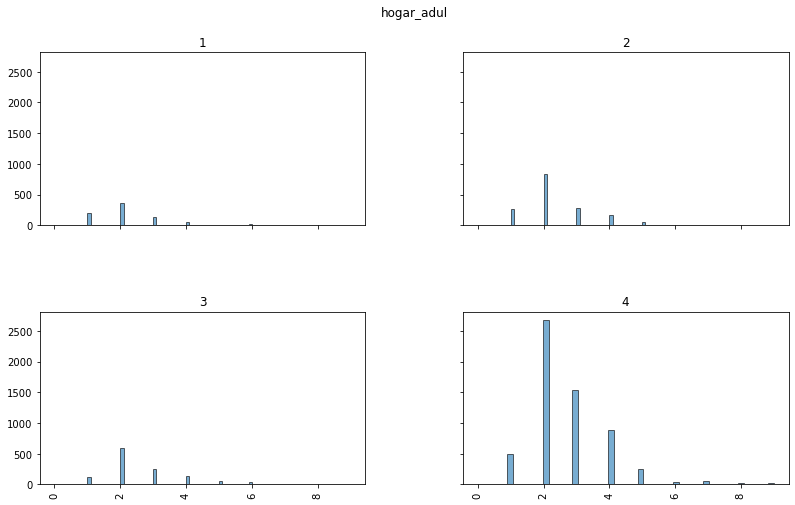

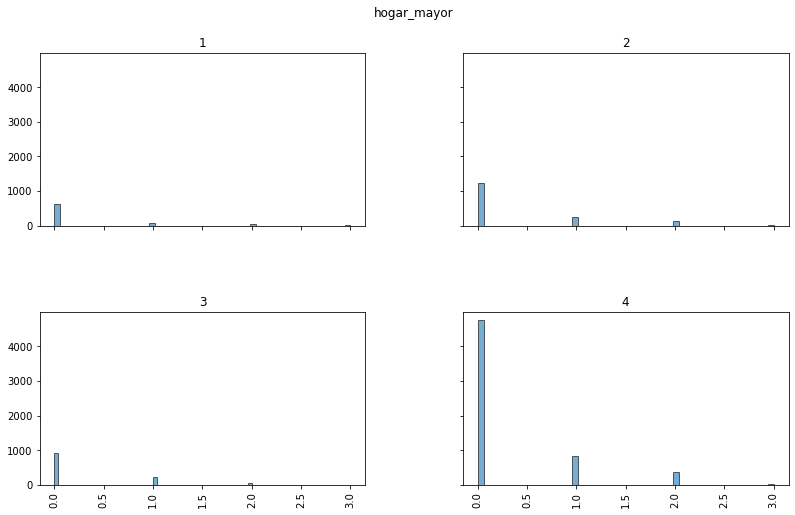

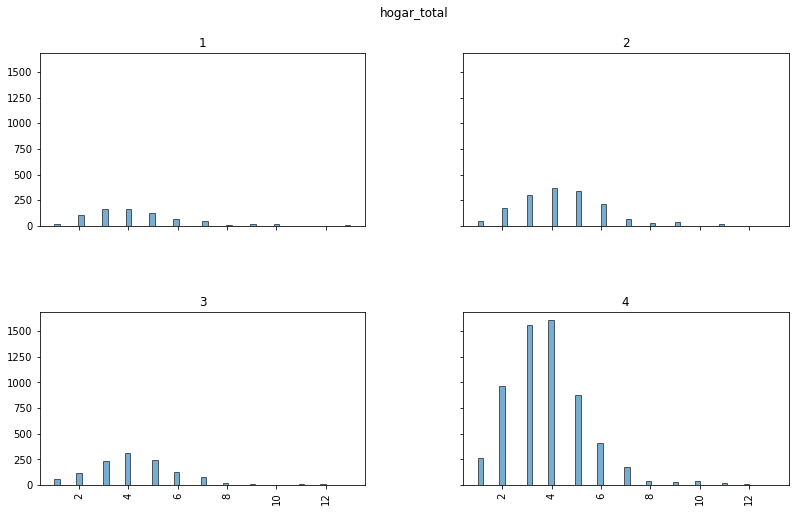

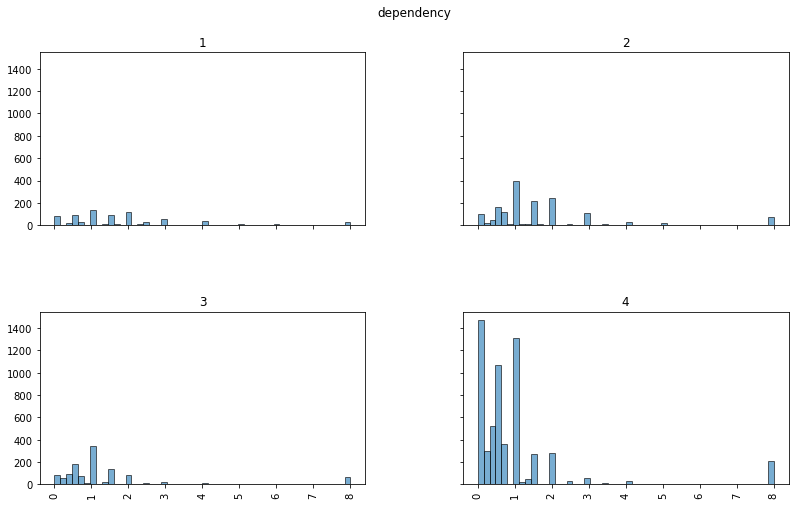

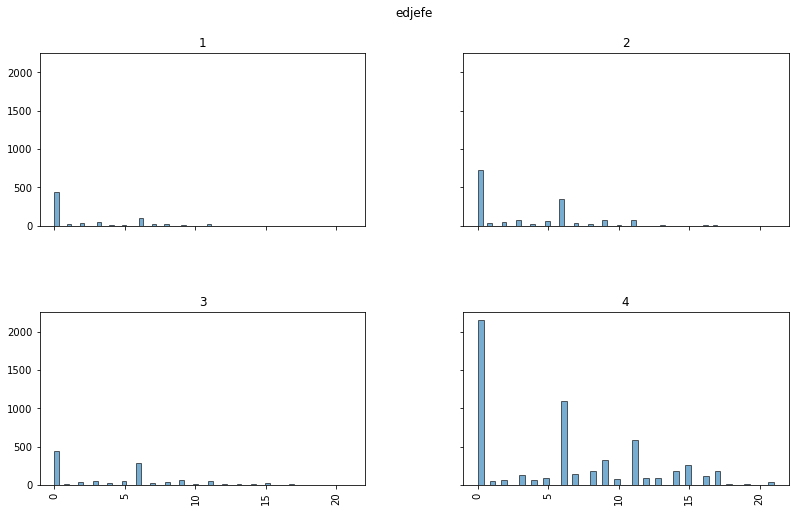

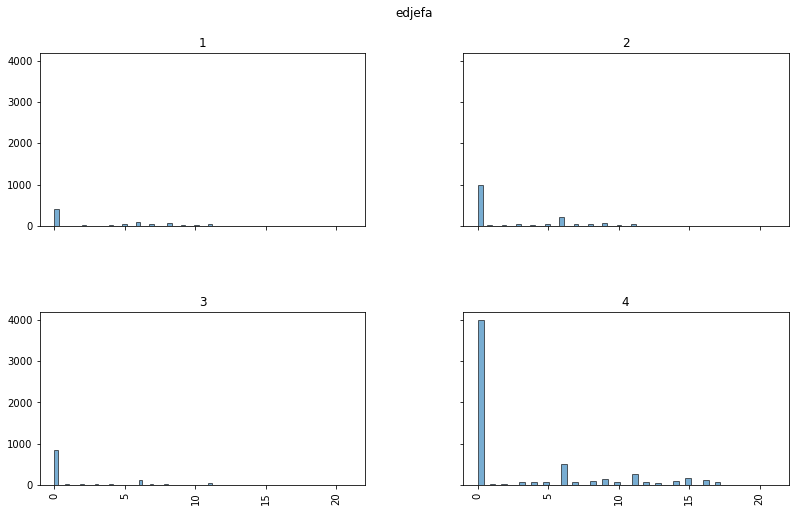

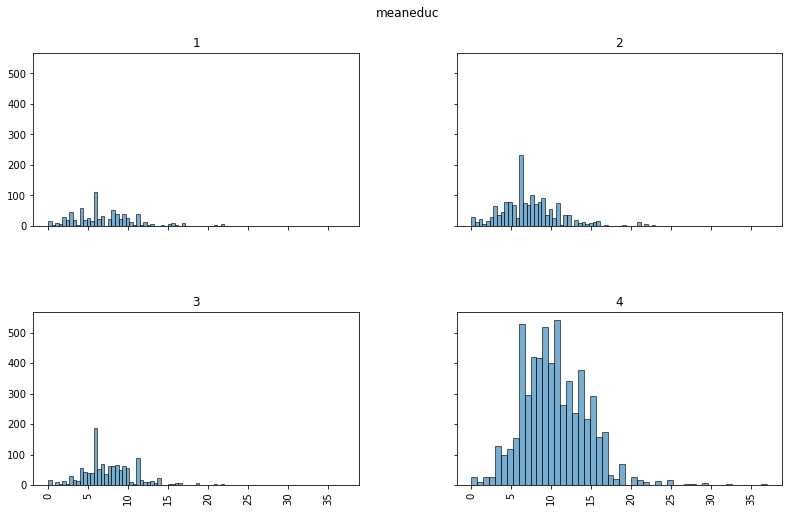

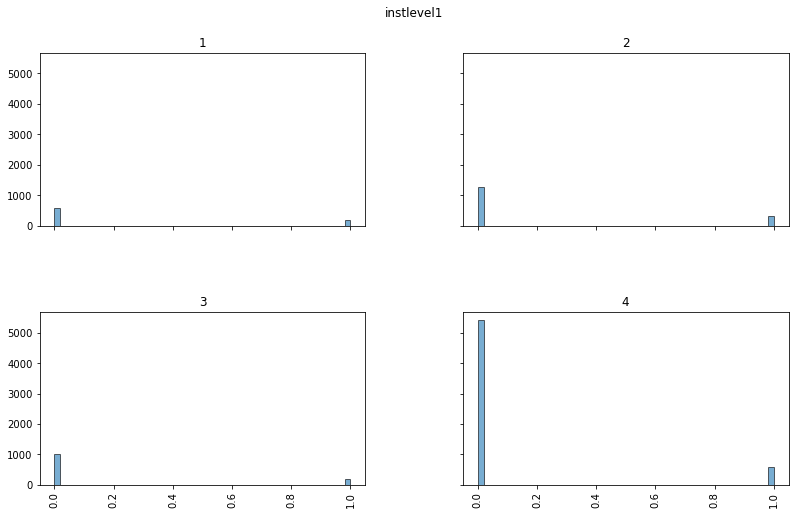

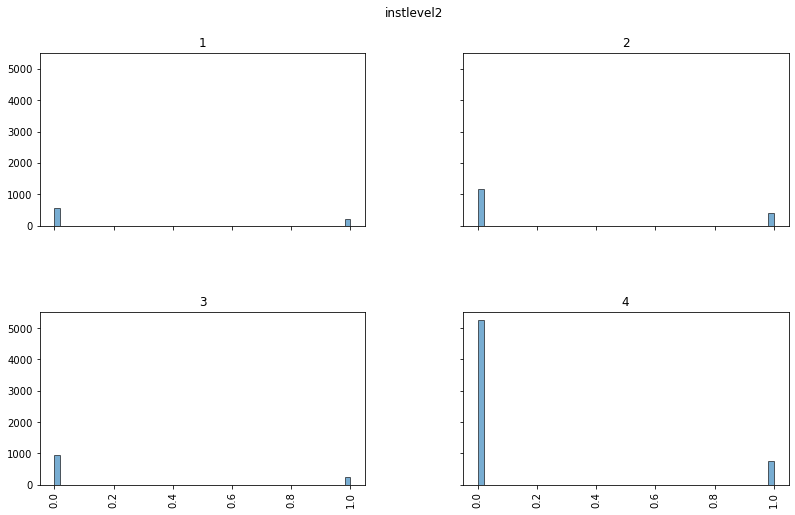

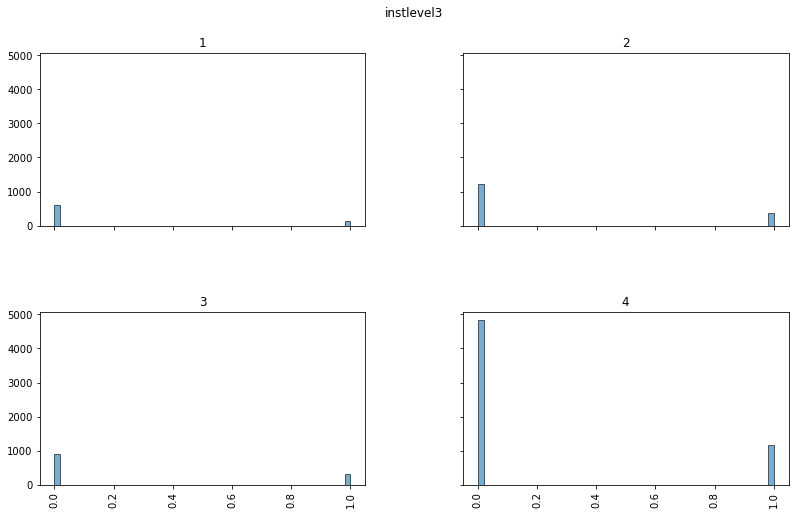

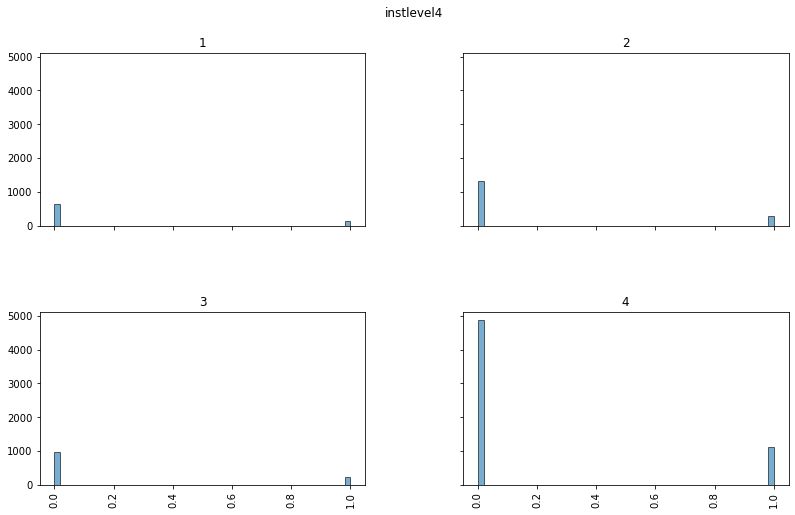

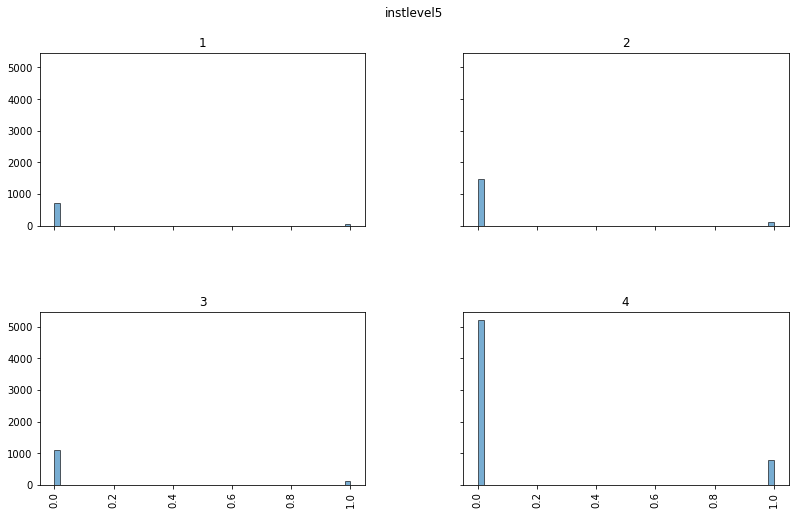

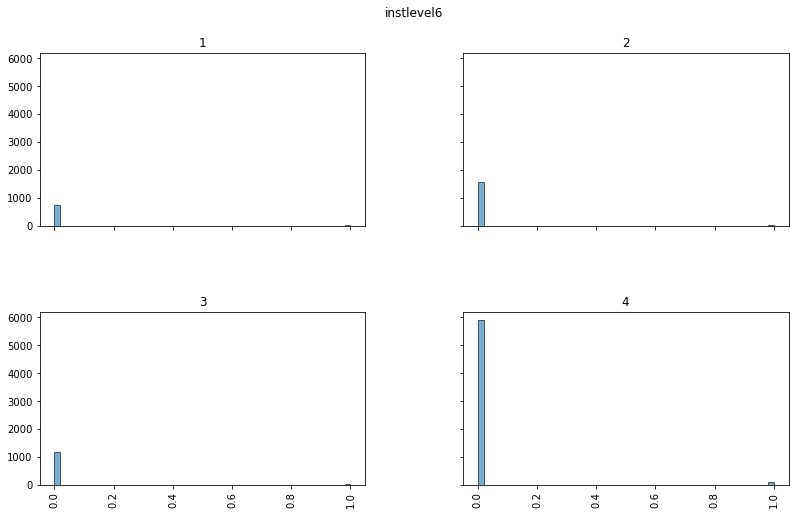

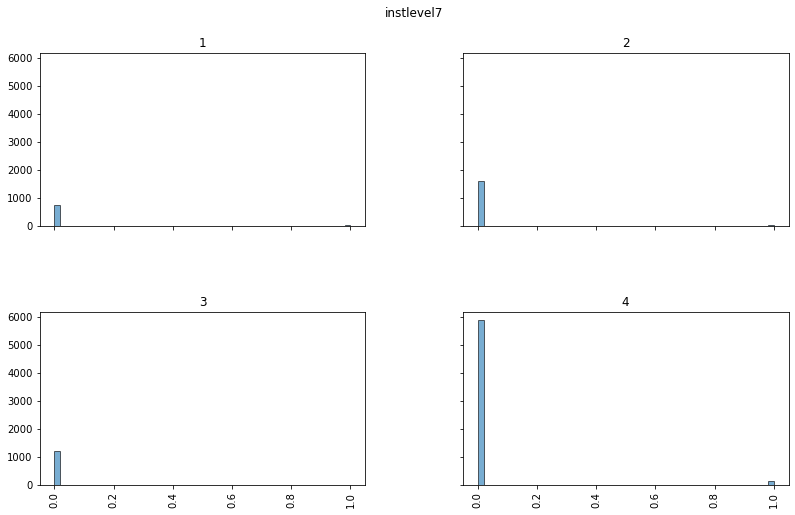

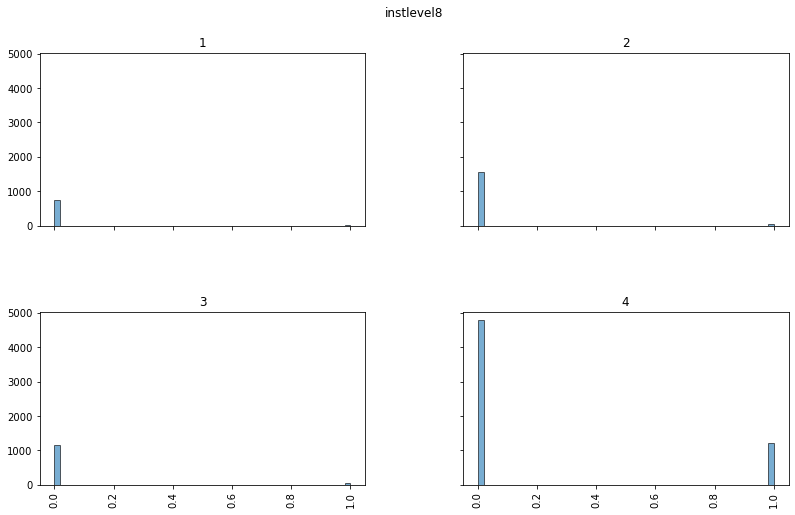

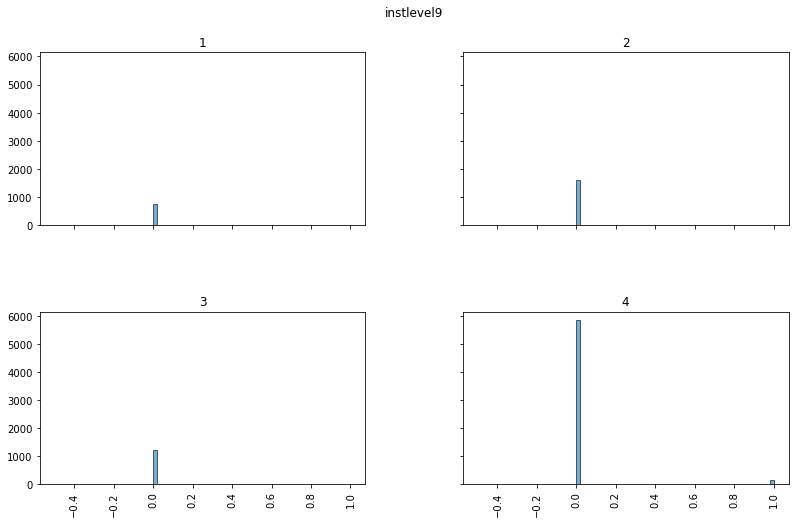

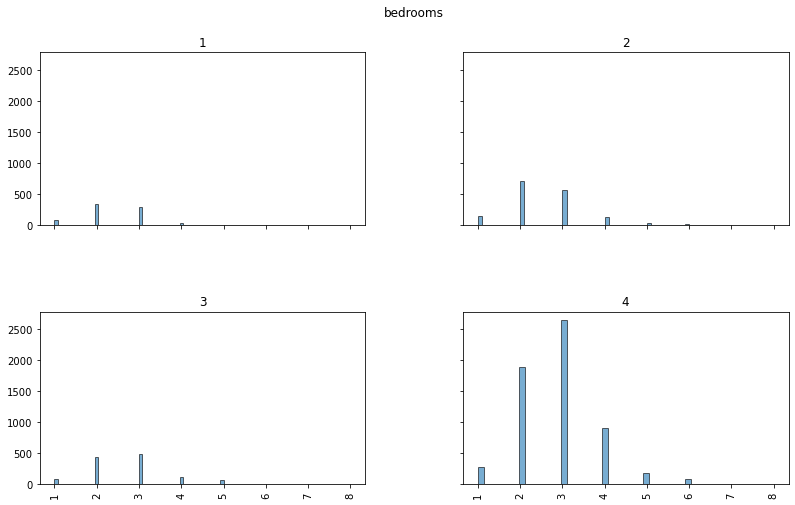

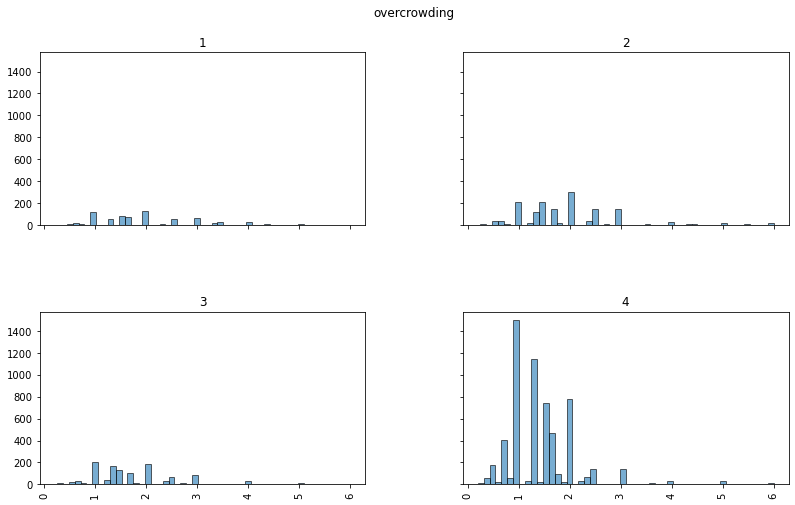

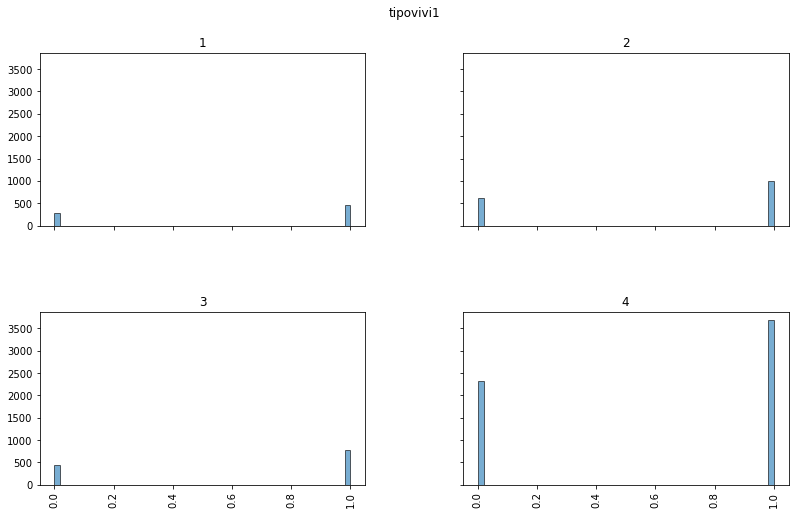

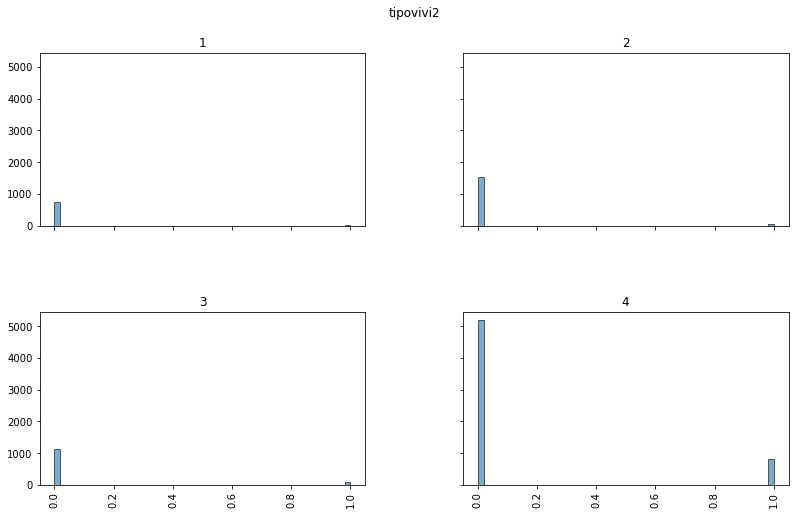

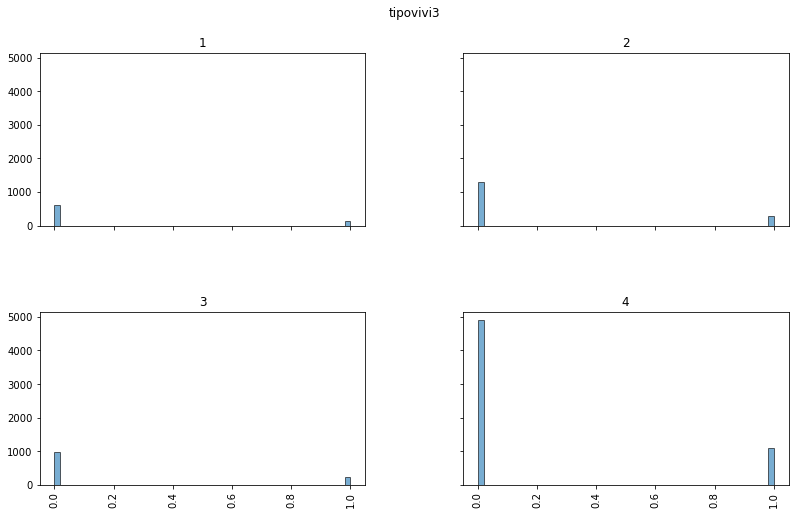

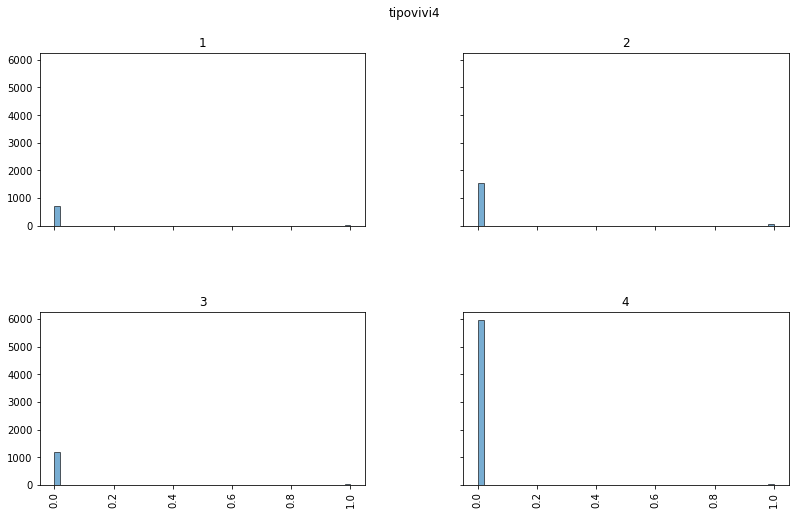

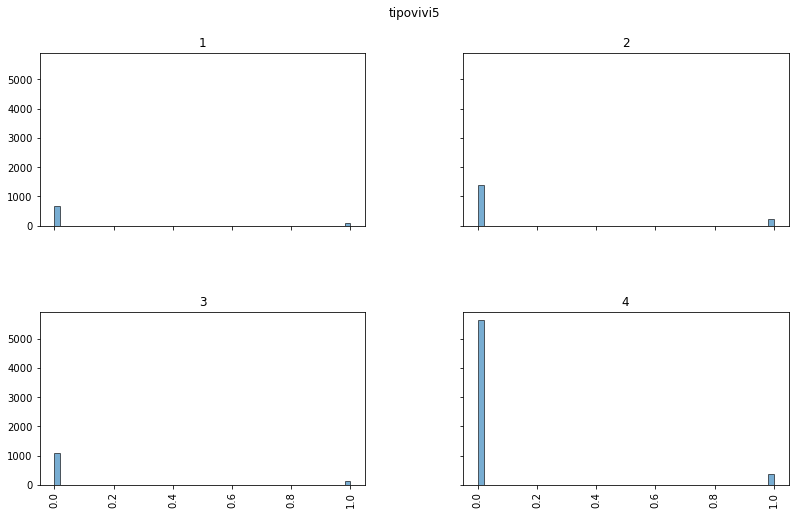

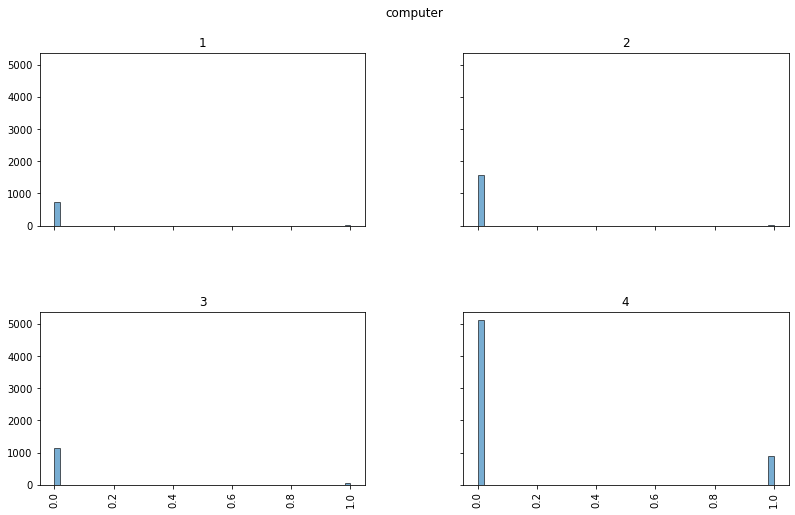

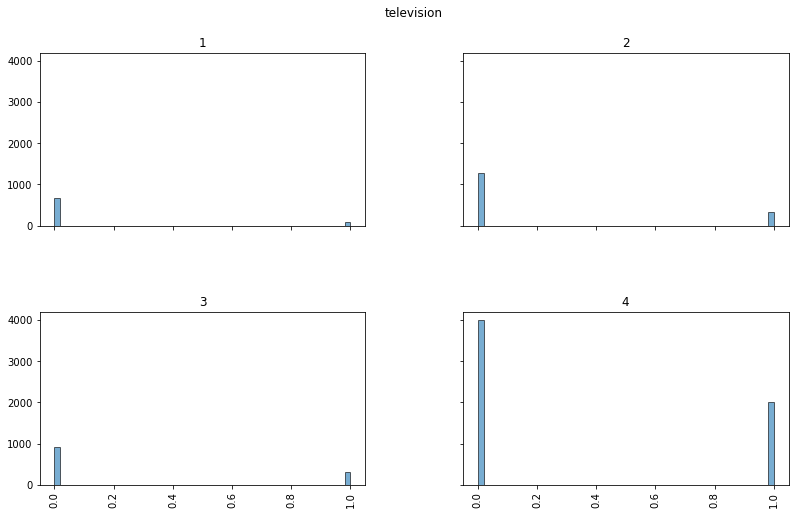

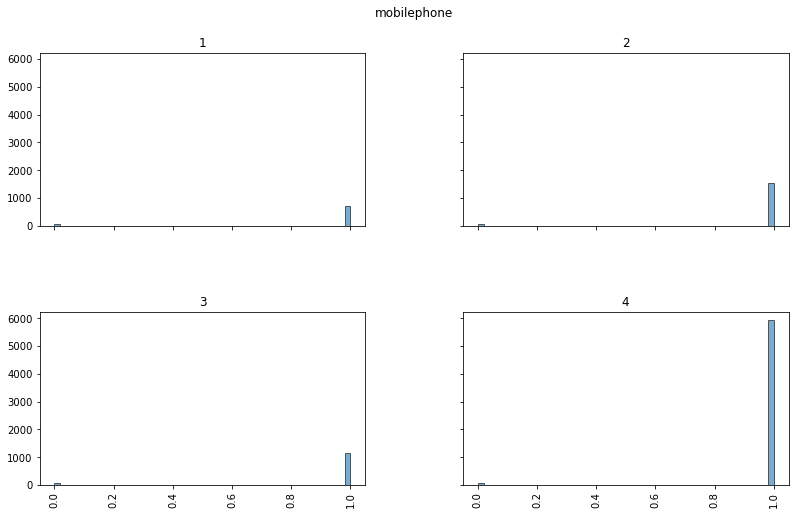

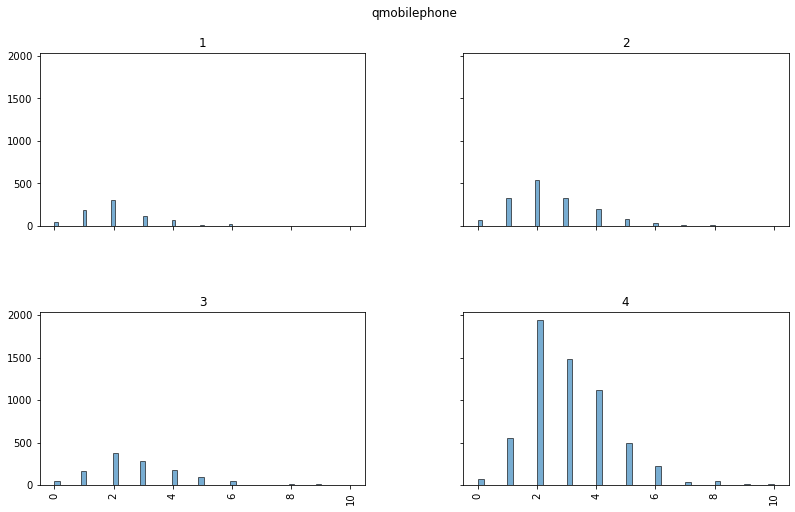

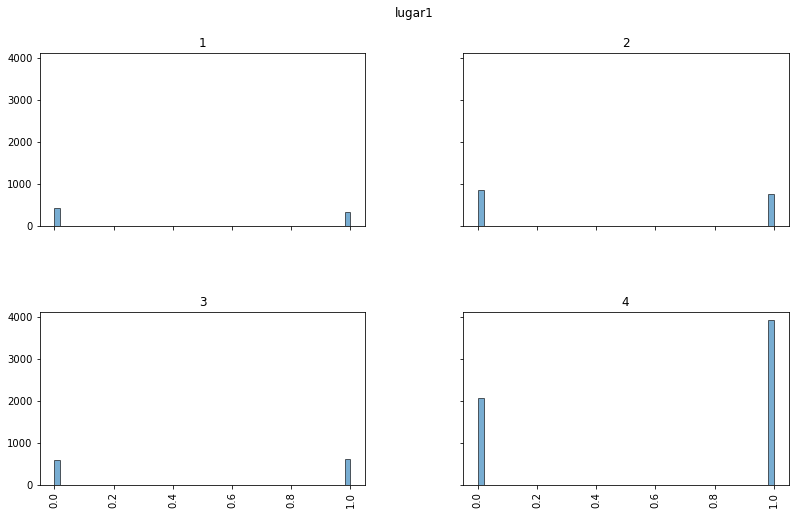

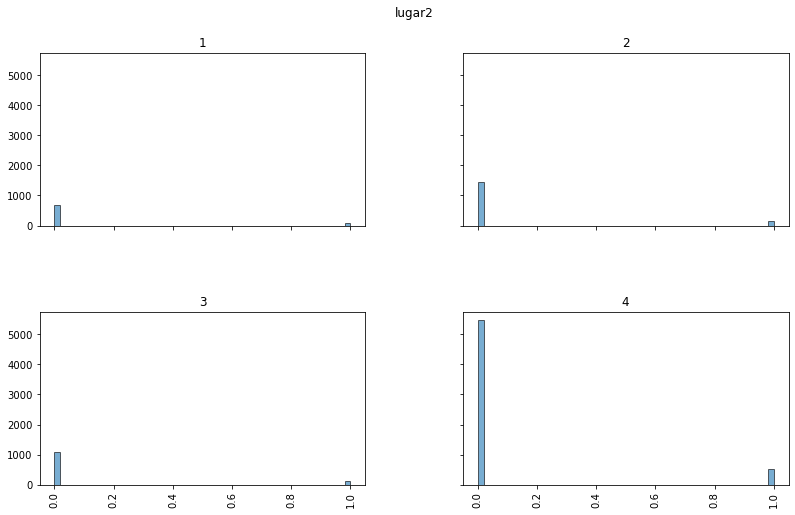

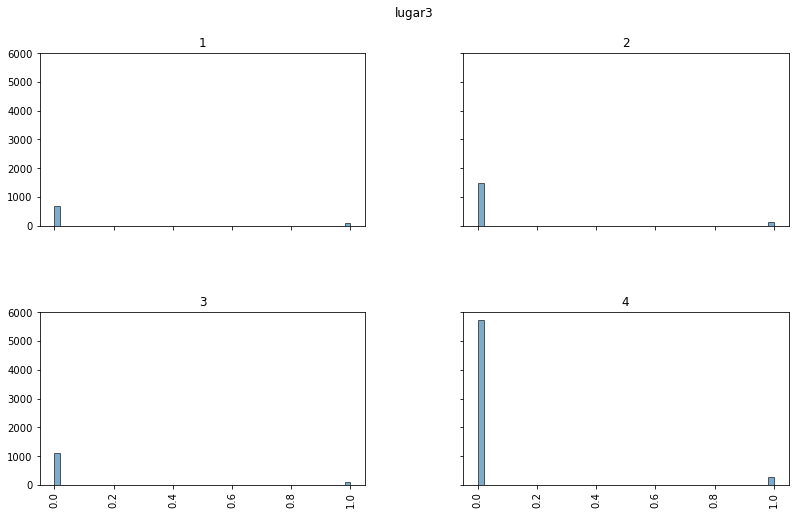

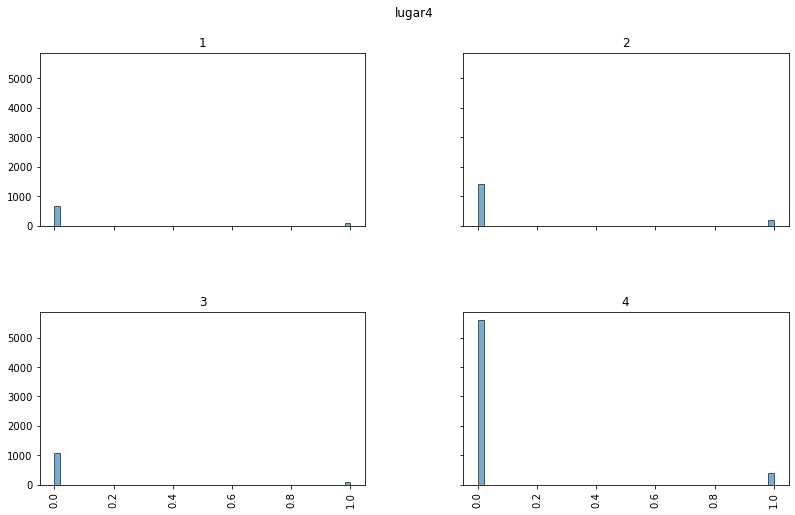

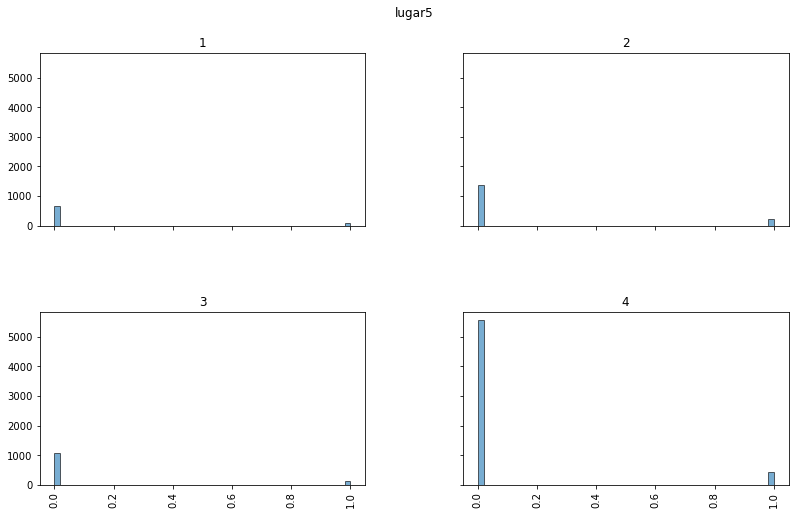

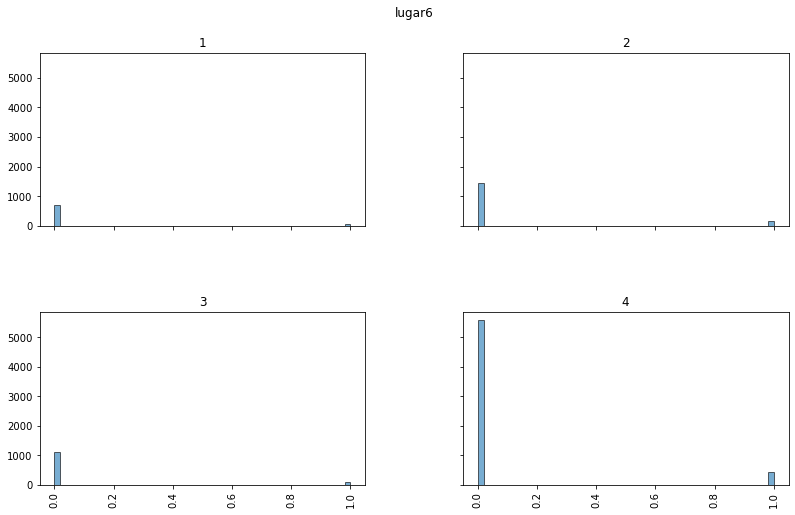

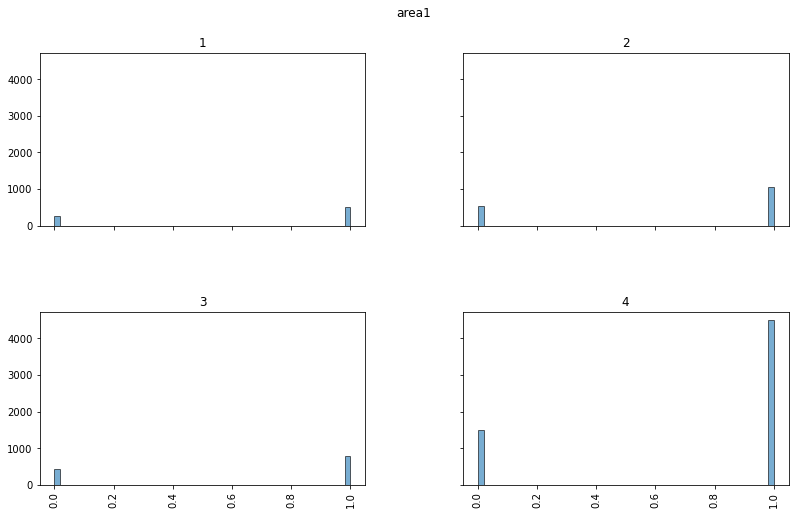

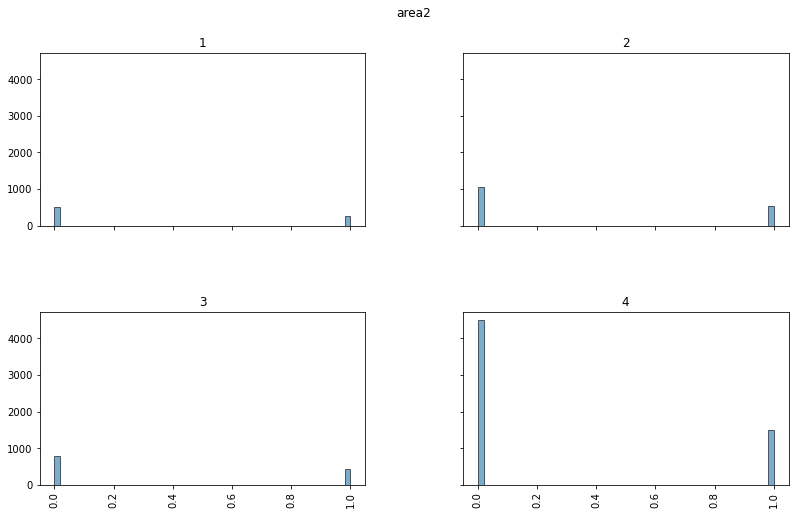

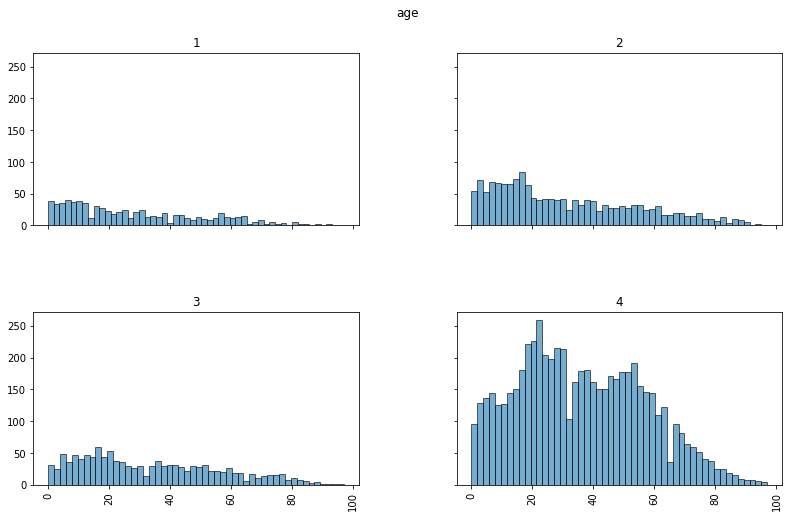

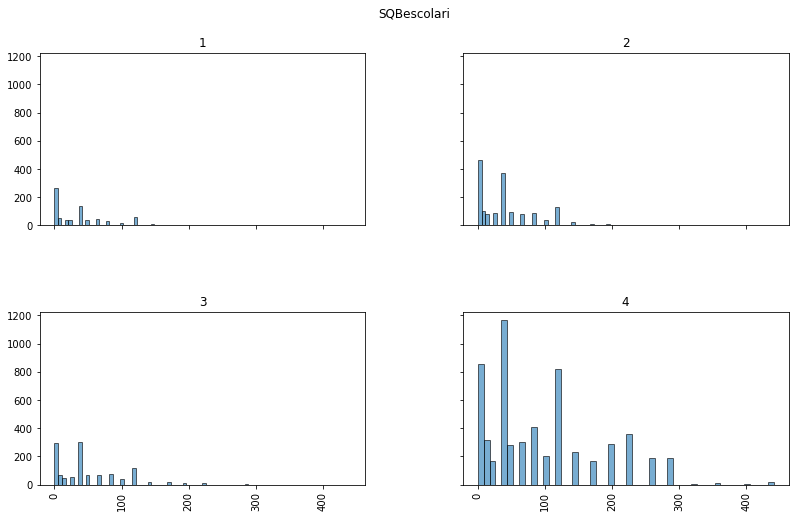

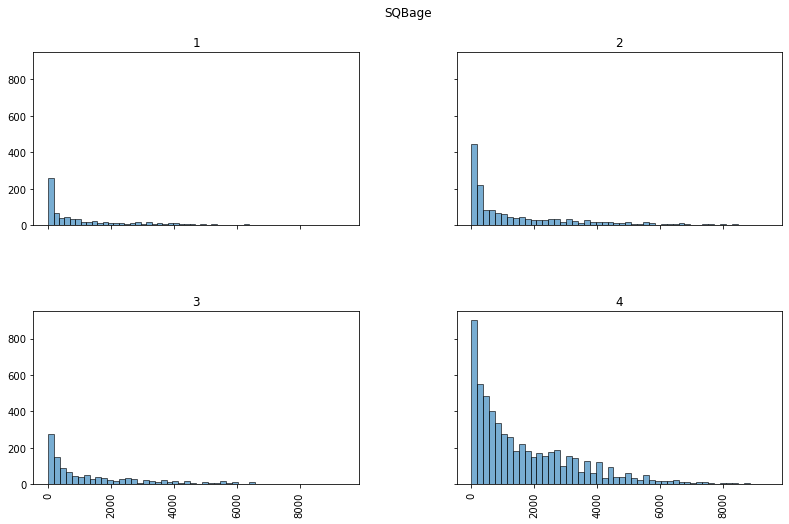

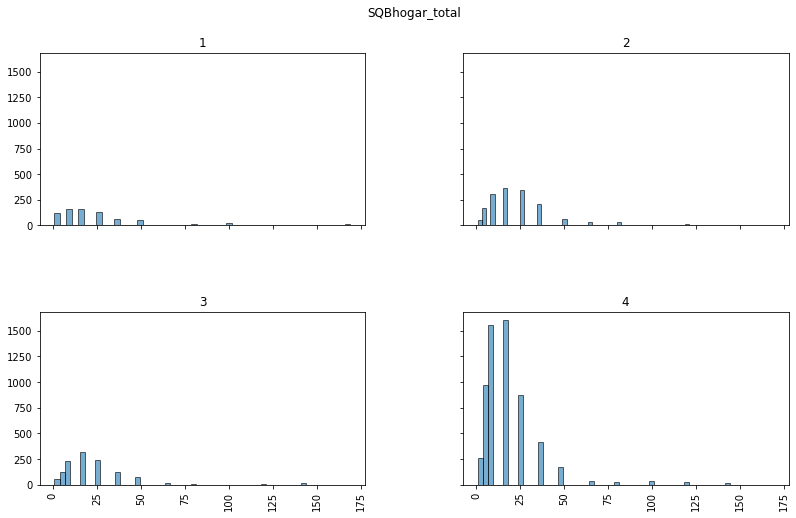

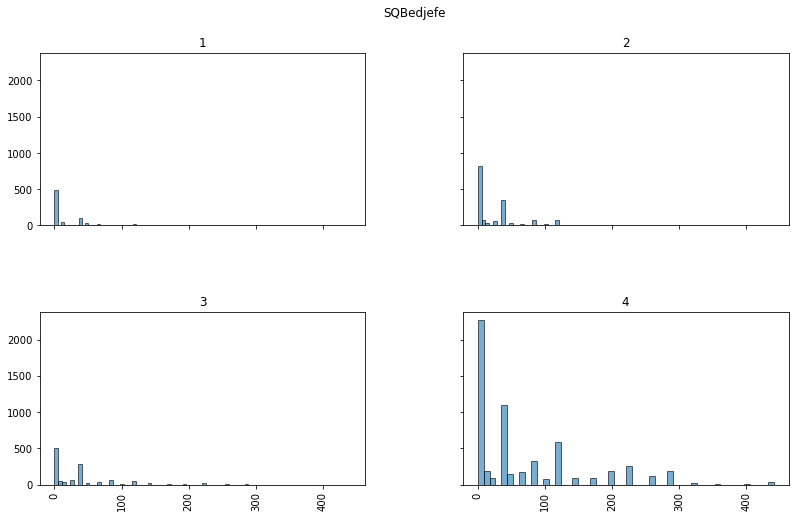

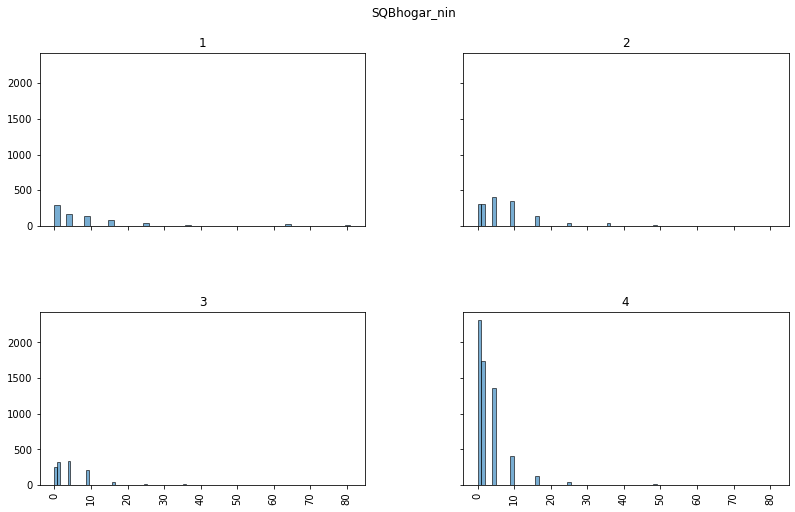

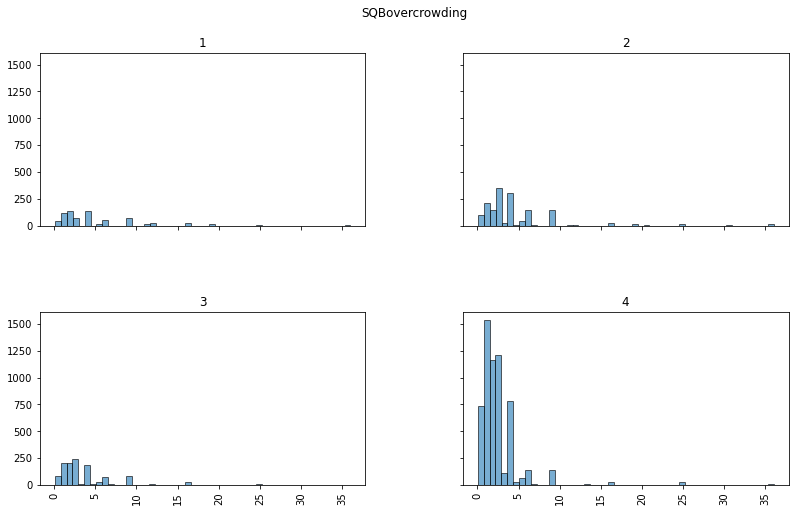

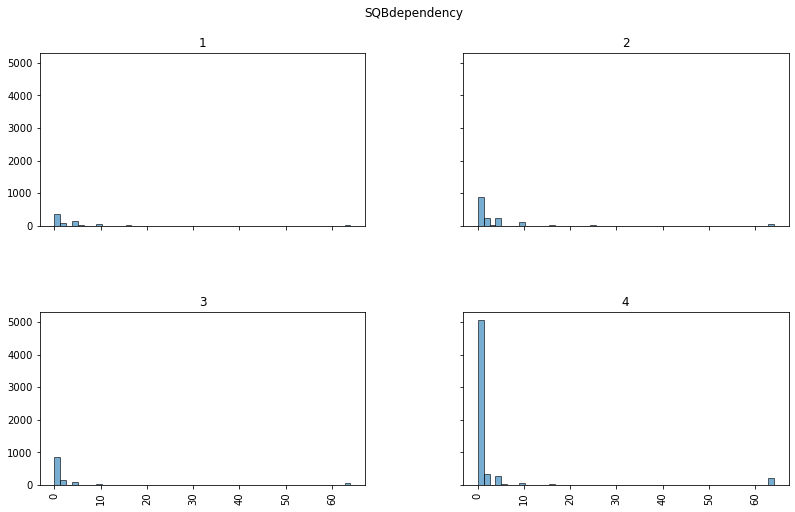

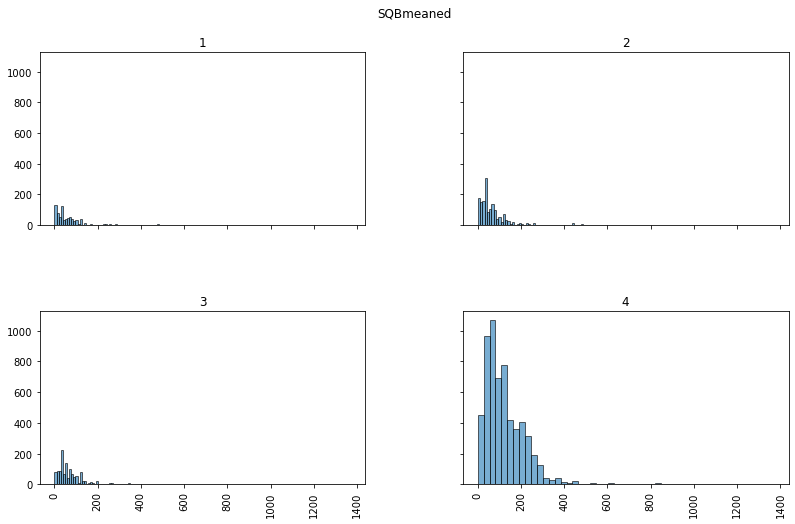

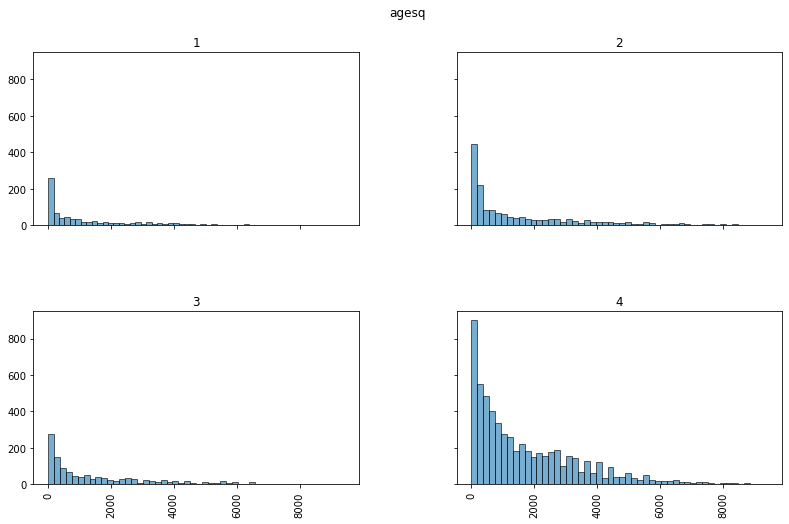

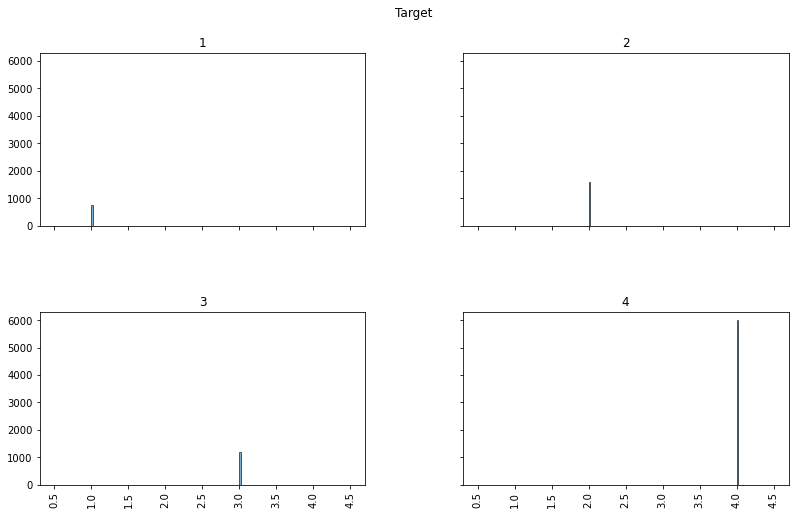

In [19]:
# visualize features as histograms per target value
for cols in df_train.columns:
    df_train[cols].hist(figsize=(13,8), bins=50, ec="k", sharey=True, sharex=True, alpha=0.6, by=df_train['Target'])
    plt.suptitle(cols)
    plt.show()

The distribution of features among the four target values seems relatively similar.

### Check if there is a house without a family head

In [20]:
# for all households with > 1 persons:
# group train data by household and get the number of unique head levels per household
heads_large = df_train[df_train['hogar_total']>1].groupby('idhogar')['parentesco1'].nunique()

# for all households with > 1 persons:
# get row index of those households that have less than 2 unique head levels
idy_large = np.where(heads_large < 2)[0]


# for all households with 1 person:
# get the head level
heads_small = df_train[df_train['hogar_total']==1]['parentesco1']

# for all households with 1 person:
# get row index of those households that have no head
idy_small = np.where(heads_small < 1)[0]

In [21]:
# list households that are likely without a family head
print(heads_large[idy_large])
print(heads_small[idy_small])

idhogar
03c6bdf85    1
053f09ebb    1
09b195e7a    1
1367ab31d    1
1bc617b23    1
374ca5a19    1
61c10e099    1
66701a0de    1
6b1b2405f    1
896fe6d3e    1
a0812ef17    1
ad687ad89    1
b1f4d89d7    1
bfd5067c2    1
c0c8a5013    1
d363d9183    1
f2bfa75c4    1
Name: parentesco1, dtype: int64
Series([], Name: parentesco1, dtype: int64)


The second list is empty: all households with 1 person have a head.

In [22]:
# check the households with > 1 persons where only one individual is recorded in the data and the individual is the head
df_train[df_train['idhogar'].isin(heads_large[idy_large].index) & df_train['parentesco1']==1]\
  [['idhogar','hogar_total','parentesco1']]

,idhogar,hogar_total,parentesco1
5129,66701a0de,2,1
9507,053f09ebb,2,1


We found 2 households in our list that have a head and need to be removed from the list of households that are without a family head.

In [23]:
# get position of these 2 households in heads_large
print(list(heads_large.index).index('66701a0de'))
print(list(heads_large.index).index('053f09ebb'))

1032
51


In [24]:
# remove these 2 households from the list of households that are without a family head
idy_large = idy_large[(idy_large != 1032) & (idy_large != 51)]

In [25]:
# number of households that are without a family head
heads_large[idy_large].size

15

15 households have no family head. We remove these households from our data:

In [26]:
# size of train data before removal
df_train.shape

(9557, 142)

In [27]:
# remove households without head from train data
df_train = df_train.drop(df_train[df_train['idhogar'].isin(heads_large[idy_large].index)].index)

In [28]:
# size of train data after removal
df_train.shape

(9534, 142)

In [29]:
print('We dropped', 9557-9534 , 'rows from the train data.')

We dropped 23 rows from the train data.


### Check whether all members of the house have the same poverty level

In [30]:
# group train data by household and get the number of unique poverty levels per household
houses = df_train.groupby('idhogar')['Target'].nunique()

# get row index of those households that have more than 1 unique poverty level
idx = np.where(houses > 1)[0]

In [31]:
# list of households that have more than 1 unique poverty level
houses[idx]

idhogar
0172ab1d9    2
03f4e5f4d    2
0511912b6    2
078a0b6e2    2
09e25d616    2
            ..
e65d4b943    2
efd3aec61    2
f006348ed    2
f7b421c2c    2
f94589d38    2
Name: Target, Length: 85, dtype: int64

In [32]:
# number of households that have more than 1 unique poverty level
houses[idx].size

85

### Set poverty level of the members and the head of the house within a family

For households that have more than 1 unique poverty level, we set the poverty level to be the poverty level of the household head.

In [33]:
# loop over households that have more than 1 unique poverty level
for house_id in houses[idx].index:
    
    # get poverty level of the household head
    head_target = df_train[(df_train['idhogar']==house_id) & (df_train['parentesco1']==1)]['Target'].values[0]
    
    # get indices of non-head household members
    house_index = df_train[(df_train['idhogar']==house_id) & (df_train['parentesco1']==0)][['Target']].index
    
    # loop over non-head household members and set their poverty level to be the poverty level of their household head
    for i in house_index:
        df_train.loc[i,'Target'] = head_target

### Count how many null values are existing in columns - Train data

In [34]:
# count number of missing values in train data
df_train.isnull().sum().sum()

22093

In [35]:
# count missing values per column in train data
df_train.isnull().sum().sort_values(ascending=False).head(10)

rez_esc           7921
v18q1             7319
v2a1              6843
meaneduc             5
SQBmeaned            5
etecho1              0
sanitario3           0
techoentrepiso       0
techocane            0
techootro            0
dtype: int64

The following five features have missing values:
- rez_esc, years behind in school: 7921 missing values, which is 83% of the data
- v18q1, number of tablets household owns: 7319 missing values, which is 77% of the data
- v2a1, monthly rent payment: 6843 missing values, which is 72% of the data
- meaneduc, average years of education for adults: 5 missing values, which is 0.05% of the data
- SQBmeaned, square of the mean years of education of adults (>=18) in the household: 5 missing values, which is 0.05% of the data

#### rez_esc

In [36]:
# check distribution of the age among all individuals whose rez_esc-value is not missing
df_train[df_train['rez_esc'].notnull()]['age'].describe()

count    1613.000000
mean       12.262244
std         3.218671
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

The minimum age is 7, and the maximum age is 17.

In [37]:
# number of unique rez_esc-values (in %) among all individuals who are 17
df_train[df_train['age']==17][['rez_esc']].value_counts()*100/df_train[df_train['age']==17].shape[0]

rez_esc
0.0        39.884393
1.0        19.075145
4.0        15.606936
2.0        15.606936
3.0         7.514451
5.0         2.312139
dtype: float64

40% of the people of age 17 have rez_esc=0. 19% of the people of age 17 have rez_esc=1.

We will replace the missing rez_esc-values by zero for all individuals who are between 7 and 19:

In [38]:
rez_esc_ind = df_train[df_train['rez_esc'].isnull() & ((df_train['age'] < 7) | (df_train['age'] > 19))][['rez_esc']].index

for i in rez_esc_ind:
    df_train.loc[i,'rez_esc'] = 0

In [39]:
# count remaining missing rez_esc-values in train data
df_train.rez_esc.isnull().sum()

349

rez_esc has 349 missing values left. Check the age of these individuals:

In [40]:
df_train[df_train['rez_esc'].isnull()]['age'].value_counts()

18    179
19    169
10      1
Name: age, dtype: int64

Except for one person who is 10 years old, all of them are 18 or 19 years old. Let's check the rez_esc-vales for individuals of age 10 and 20:

In [41]:
# number of unique rez_esc-values (in %) among all individuals who are 20
df_train[df_train['age']==20][['rez_esc']].value_counts()*100/df_train[df_train['age']==20].shape[0]

rez_esc
0.0        100.0
dtype: float64

In [42]:
# number of unique rez_esc-values (in %) among all individuals who are 10
df_train[df_train['age']==10][['rez_esc']].value_counts()*100/df_train[df_train['age']==10].shape[0]

rez_esc
0.0        84.444444
1.0        14.074074
3.0         0.740741
dtype: float64

We will replace the missing rez_esc-values by 0:

In [43]:
df_train['rez_esc'].fillna(0, inplace=True)

In [44]:
# count missing values per column in train data
df_train.isnull().sum().sort_values(ascending=False).head()

v18q1          7319
v2a1           6843
SQBmeaned         5
meaneduc          5
abastaguano       0
dtype: int64

#### v18q1

In [45]:
# check distribution of v18q (owns a tablet or not) among all individuals whose v18q1-value is missing
df_train[df_train['v18q1'].isnull()]['v18q'].value_counts()

0    7319
Name: v18q, dtype: int64

All individuals whose v18q1-value is missing do not have a tablet. Hence, we will replace the missing v18q1-values by 0:

In [46]:
df_train['v18q1'].fillna(0, inplace=True)

In [47]:
# count missing values per column in train data
df_train.isnull().sum().sort_values(ascending=False).head()

v2a1           6843
SQBmeaned         5
meaneduc          5
abastaguano       0
sanitario2        0
dtype: int64

#### v2a1

In [48]:
# percentage count of tipovivi1 (own and fully paid house) among all individuals whose v2a1-value is missing
df_train[(df_train['v2a1'].isnull()) & (df_train['tipovivi1']==1)].shape[0]*100/df_train[df_train['v2a1'].isnull()].shape[0]

86.17565395294461

In [49]:
# percentage count of tipovivi2 (own, paying in installments) among all individuals whose v2a1-value is missing
df_train[(df_train['v2a1'].isnull()) & (df_train['tipovivi2']==1)].shape[0]*100/df_train[df_train['v2a1'].isnull()].shape[0]

0.0

In [50]:
# percentage count of tipovivi3 (rented) among all individuals whose v2a1-value is missing
df_train[(df_train['v2a1'].isnull()) & (df_train['tipovivi3']==1)].shape[0]*100/df_train[df_train['v2a1'].isnull()].shape[0]

0.0

In [51]:
# percentage count of tipovivi4 (precarious) among all individuals whose v2a1-value is missing
df_train[(df_train['v2a1'].isnull()) & (df_train['tipovivi4']==1)].shape[0]*100/df_train[df_train['v2a1'].isnull()].shape[0]

2.3819962004968582

In [52]:
# percentage count of tipovivi5 (other: assigned, borrowed) among all individuals whose v2a1-value is missing
df_train[(df_train['v2a1'].isnull()) & (df_train['tipovivi5']==1)].shape[0]*100/df_train[df_train['v2a1'].isnull()].shape[0]

11.442349846558526

Among the people whose v2a1-value is missing:
- 86% own and fully paid house
- 11% have other status (assigned, borrowed)
- 2% are precarious

We will replace the missing v2a1-values by 0:

In [53]:
df_train['v2a1'].fillna(0, inplace=True)

In [54]:
# count missing values per column in train data
df_train.isnull().sum().sort_values(ascending=False).head()

SQBmeaned      5
meaneduc       5
Target         0
abastaguano    0
sanitario2     0
dtype: int64

### Remove null value rows of the target variable

For the remaining 10 missing values, we will remove the entire rows from the training data (including the target):

In [55]:
# size of train data before removal
df_train.shape

(9534, 142)

In [56]:
# drop missing values
df_train.dropna(inplace=True)

In [57]:
# size of train data after removal
df_train.shape

(9529, 142)

In [58]:
print('We dropped', 9534-9529 , 'rows from the train data.')

We dropped 5 rows from the train data.


### Remove squared columns from train and test data

In [59]:
df_train = df_train.drop(['SQBescolari','SQBage','SQBhogar_total','SQBedjefe','SQBhogar_nin',
                          'SQBovercrowding','SQBdependency','SQBmeaned','agesq'], axis=1)

df_test = df_test.drop(['SQBescolari','SQBage','SQBhogar_total','SQBedjefe','SQBhogar_nin',
                        'SQBovercrowding','SQBdependency','SQBmeaned','agesq'], axis=1)

### Check for duplicate columns in train data

In [60]:
# collect all the duplicate columns in the train set
df_train.T.duplicated()[df_train.T.duplicated()].index

Index(['hhsize', 'hogar_total'], dtype='object')

In [61]:
# remove these duplicate columns from the train and test dataset
df_train = df_train.drop(['hhsize', 'hogar_total'], axis=1)
df_test = df_test.drop(['hhsize', 'hogar_total'], axis=1)

### Remove idhogar variable from train and test data

In [62]:
df_train = df_train.drop(['idhogar'], axis=1)
df_test = df_test.drop(['idhogar'], axis=1)

### Handle null values in test data

In [63]:
# count missing values per column in test data
df_test.isnull().sum().sort_values(ascending=False).head(10)

rez_esc           19653
v18q1             18126
v2a1              17403
meaneduc             31
techozinc             0
techoentrepiso        0
techocane             0
techootro             0
coopele               0
cielorazo             0
dtype: int64

As done with the train data, we will replace the missing values in rez_esc, v18q1, and v2a1 by zero.
For the remaining missing values, we will remove the entire rows from the test data.

In [64]:
df_test['rez_esc'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

In [65]:
df_test.dropna(inplace=True)

### Perform dimensionality reduction

In [66]:
# separate target from features

# train and test features
df_train_features = df_train.drop(['Target'], axis=1)
df_test_features = df_test.copy()

# target
target = df_train['Target']

In [130]:
# initiate PCA
# choose n_components; here, we reduce the number of components originally present in our data to 10
sklearn_pca = PCA(n_components=15)

In [131]:
# fit PCA on our training data
sklearn_pca.fit(df_train_features)

PCA(n_components=15)

In [132]:
# apply dimensionality reduction to train data
x_train_transformed = sklearn_pca.transform(df_train_features)

In [133]:
# size of reduced train dataset
print(x_train_transformed.shape)

(9529, 15)


In [134]:
# apply dimensionality reduction to test data
x_test_transformed = sklearn_pca.transform(df_test_features)

# size of reduced test dataset
print(x_test_transformed.shape)

(23825, 15)


### Split the data to testing and training data to measure accuracy of the model

In [135]:
# convert target to array
y_train_values = target.values

In [136]:
x_mytrain, x_mytest, y_mytrain, y_mytest = train_test_split(x_train_transformed,y_train_values,test_size=0.2,random_state=4)

In [137]:
# sizes of testing and training data
print(x_mytrain.shape)
print(y_mytrain.shape)
print(x_mytest.shape)
print(y_mytest.shape)

(7623, 15)
(7623,)
(1906, 15)
(1906,)


### Predict the accuracy using random forest classifier

In [138]:
classifier_forest = RandomForestClassifier()
scale = StandardScaler()

pipeline = Pipeline(steps=[('scale', scale),('classifier_forest', classifier_forest)])

# fit classifier on training data
pipeline.fit(x_mytrain, y_mytrain)

# predict for our testing set
y_predict_forest = pipeline.predict(x_mytest)

# check accuracy of our model
accuracy_forest = accuracy_score(y_predict_forest,y_mytest)
print(accuracy_forest)

0.7843651626442812


78.4% accuracy.

In [139]:
# classification report
print(classification_report(y_mytest,y_predict_forest))

              precision    recall  f1-score   support

           1       0.81      0.39      0.53       143
           2       0.75      0.54      0.63       317
           3       0.84      0.36      0.51       242
           4       0.79      0.98      0.87      1204

    accuracy                           0.78      1906
   macro avg       0.80      0.57      0.63      1906
weighted avg       0.79      0.78      0.76      1906



In [140]:
# confusion matrix
print(confusion_matrix(y_mytest,y_predict_forest))

[[  56   15    4   68]
 [   9  171    7  130]
 [   4   25   88  125]
 [   0   18    6 1180]]


### Predict "x_test_transformed"

In [141]:
preds = pipeline.predict(x_test_transformed)
preds

array([4, 4, 4, ..., 2, 2, 2], dtype=int64)

### Check the accuracy using random forest with cross validation

In [142]:
cv_score = cross_val_score(pipeline, x_mytrain, y_mytrain, cv = 10, scoring="accuracy")
print(cv_score)

[0.78768021 0.79685452 0.78112713 0.78740157 0.7808399  0.80052493
 0.76377953 0.7664042  0.78346457 0.76902887]


Random forest with cross validation confirms the accuracy of about 78.4%.

### Random forest with cross validation to find best parameters

In [143]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'classifier_forest__n_estimators': [100, 200, 300, 500, 600],
    'classifier_forest__max_features': ['auto', 'sqrt', 'log2']
    #'classifier_forest__max_depth': [80, 90, 100, 110],
    #'classifier_forest__min_samples_leaf': [3, 4, 5],
    #'classifier_forest__min_samples_split': [8, 10, 12],
}
search = GridSearchCV(pipeline, param_grid, n_jobs=-1)
search.fit(x_mytrain, y_mytrain)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.777):
{'classifier_forest__max_features': 'log2', 'classifier_forest__n_estimators': 300}


In [144]:
classifier_forest_cv = RandomForestClassifier(n_estimators=300, max_features='log2')

pipeline_cv = Pipeline(steps=[('scale', scale),('classifier_forest_cv', classifier_forest_cv)])

# fit classifier on training data
pipeline_cv.fit(x_mytrain, y_mytrain)

# predict for our testing set
y_predict_forest_cv = pipeline_cv.predict(x_mytest)

# check accuracy of our model
accuracy_forest_cv = accuracy_score(y_predict_forest_cv,y_mytest)
print(accuracy_forest_cv)

0.789087093389297


78.9% accuracy.

In [145]:
# classification report
print(classification_report(y_mytest,y_predict_forest_cv))

              precision    recall  f1-score   support

           1       0.88      0.42      0.57       143
           2       0.75      0.55      0.63       317
           3       0.90      0.36      0.52       242
           4       0.78      0.98      0.87      1204

    accuracy                           0.79      1906
   macro avg       0.83      0.58      0.65      1906
weighted avg       0.80      0.79      0.76      1906



In [146]:
# confusion matrix
print(confusion_matrix(y_mytest,y_predict_forest_cv))

[[  60   15    2   66]
 [   5  173    4  135]
 [   1   27   88  126]
 [   2   15    4 1183]]


#### Predict "x_test_transformed"

In [147]:
preds_cv = pipeline_cv.predict(x_test_transformed)
preds_cv

array([4, 4, 4, ..., 3, 3, 3], dtype=int64)